# Flowmetrics – Validation

This notebook evaluates the performance and internal consistency of large language models (LLMs) in predicting societal impact trajectories as defined by the Flowmetrics framework. It assesses model outputs along three complementary axes: stage-level classification performance, sequence-level coherence, and cross-model agreement.

### Objective

To systematically evaluate the quality, structure, and consistency of predicted impact trajectories across LLMs using a suite of custom metrics grounded in multi-label classification, sequence analysis, and inter-model agreement.

### Evaluated Models

The validation covers seven state-of-the-art LLMs spanning both open-source and proprietary families, all used in a zero-shot setting with a unified prompt and output pipeline:
- **DeepSeek-V3**  
- **Mixtral 8x22B**  
- **GPT-3.5-Turbo**  
- **GPT-4o**  
- **GPT-4o-mini**  
- **Claude 3.7 Sonnet**  
- **Claude 3.5 Haiku**

These models were selected for their generative capabilities, structured reasoning potential, and diversity in architecture and training.

### Structure

#### 1. Stage-Level Performance  
We assess how accurately each model identifies individual impact stages — **Reach**, **Engagement**, **Feedback**, **Influence**, and **Outcome** — for each research topic pair.  
- **Proxy Labels:** In the absence of a gold standard, we use a score thresholding strategy: a stage is considered present if its cumulative platform evidence score exceeds 0.0.  
- **Metrics:** Accuracy, precision, recall, and F1-score are computed globally and per stage to reveal both overall and dimension-specific performance.

#### 2. Sequence-Level Coherence  
We evaluate whether predicted stage combinations follow logically progressive trajectories using three structural metrics:  
- **Canonical Order Adherence:** Do stages follow the expected sequence `[Reach → Engagement → Influence → Outcome]` (even if some are skipped)?  
- **Progressive Inclusion Consistency (PIC):** Are higher stages supported by all earlier ones in the prediction?  
- **Path Coherence Score:** What proportion of the predicted sequence aligns with the canonical flow, as measured by the length of the longest matching subsequence?

These metrics reflect complementary notions of coherence — from strict ordering to soft structural alignment.

#### 3. Cross-Model Agreement  
We analyse how consistent the predictions are across different LLMs in terms of both stage selection and ordering:  
- **Stage Agreement (Jaccard Similarity):** How often do models predict the same set of stages for a topic pair?  
- **Stage Order Agreement (Kendall’s Tau):** How similarly do models rank the canonical stages when predicted?

Together, these analyses provide insight into model performance, structural reasoning, and inter-model convergence in societal impact classification.

---

### Prompt used for generating predictions

```text
You are an expert in research impact analysis. Your task is to assess the impact of a pair of research topics based on structured evidence of platform co-mentions and shared concepts.

This is a multi-label classification problem. Your goal is to classify all impact stages as either supported or not, based on the strength and relevance of the evidence for each stage.

---

Impact Stages:

- Reach: Broad dissemination of research to general audiences via mass communication platforms (e.g., Twitter, Facebook, Wikipedia).
- Engagement: Active interaction, discussion, or interpretation of research in community-driven forums (e.g., Blogs, Reddit, YouTube, Mendeley).
- Feedback: Scholarly reactions or critical appraisals, often indicating academic interest (e.g., Peer Review).
- Influence: Contribution to discourse in authoritative contexts (e.g., citations via CrossRef, media coverage via News).
- Outcome: Tangible societal or technological effects arising from research (e.g., Policy documents, Patents).

---

Important Notes:

- Platform values are normalised per platform and impact dimension at the topic level (0.0 = no evidence, 1.0 = maximum evidence). For topic pairs, scores are summed (range: 0.0–2.0) to reflect combined impact.
- Classify all impact stages with meaningful or emerging support, considering the total cumulative evidence across platforms, even if individual platform scores are low.
- Err slightly on the side of inclusiveness: if multiple signals exist across platforms, prefer assigning the stage rather than omitting it.
- If cumulative evidence across all platforms for a stage is strictly zero, assign only the "Reach" stage.

---

Now classify this pair:

- Topic 1: {topic_1}  
- Topic 2: {topic_2}  
- Shared Concepts: {shared_concepts}

Platform Co-mention Evidence (normalised values):  
{full_platform_lines}

---

You must begin your output exactly with:

Impact Stages with Sufficient Support: [list of stages]

Followed by:

Impact Summary:
Write a concise (2–4 sentence) summary explaining the evidence for each assigned impact stage. Mention the key platforms and shared concepts that support each stage. Highlight how cumulative evidence across platforms contributed to classification, even if individual signals are small.

### Real-world example used for evaluation

- **Topic 1**: optimization
- **Topic 2**: combinatorial problems
- **Shared Concepts**: combinatorial problems, combinatorial optimization
- **Platform Co-mention Evidence (normalised values)**: Twitter: 0.111, Facebook: 0.153, Wikipedia: 0.278, Blogs: 0.0, Reddit: 0.145, Videos: 0.167, Mendeley: 0.0, News: 0.0, Citation_crossref: 0.141, Policy: 0.0, Patents: 0.072

This specific example illustrates how evidence across dissemination, community engagement, and scholarly citation platforms is aggregated and presented to the model for stage classification. Despite relatively modest scores, the model is expected to consider cumulative signals across multiple platforms and err on the side of inclusion when assigning supported impact stages.

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from scipy.interpolate import make_interp_spline
from utils import parse_stringified_columns
from scipy.stats import gaussian_kde, kendalltau
from config import models, impact_stages, stage_order
from collections import Counter

In [106]:
# project directory
project_dir = Path(".").resolve().parent

In [107]:
DATASET_FILE = project_dir / "data" / "flowmetrics-predictions.csv"

In [108]:
df = pd.read_csv(DATASET_FILE, delimiter=",", header=0, encoding='utf-8', engine='python')
df

,topic_1_id,topic_1_name,topic_2_id,topic_2_name,shared_concepts,reach,engagement,feedback,influence,outcome,...,raw_response_claude-3-7-sonnet-20250219,predicted_stages_claude-3-5-haiku-20241022,impact_summary_claude-3-5-haiku-20241022,raw_response_claude-3-5-haiku-20241022,predicted_stages_deepseek-chat,impact_summary_deepseek-chat,raw_response_deepseek-chat,predicted_stages_open-mixtral-8x22b,impact_summary_open-mixtral-8x22b,raw_response_open-mixtral-8x22b
0,0,optimization,1,combinatorial problems,"['combinatorial problems', 'combinatorial opti...","[('Twitter', 0.11089738228652672), ('Facebook'...","[('Blogs', 0.0), ('Reddit', 0.1454545454545454...","[('Peers', 0.0), ('Expert', 0.0)]","[('News', 0.0), ('Citation_crossref', 0.140965...","[('Policy', 0.0), ('Patents', 0.07159904534606...",...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",The research topics of optimization and combin...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",- **Reach**: Broad dissemination is supported ...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']","The pair of topics ""optimization"" and ""combina...","Impact Stages with Sufficient Support: Reach, ..."
1,0,optimization,5,genetic selection,['genetic algorithms'],"[('Twitter', 0.12335870201555574), ('Facebook'...","[('Blogs', 0.0), ('Reddit', 0.1090909090909091...","[('Peers', 0.0), ('Expert', 0.0)]","[('News', 0.0), ('Citation_crossref', 0.149943...","[('Policy', 0.0), ('Patents', 0.09665871121718...",...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",The research topics of optimization and geneti...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",- **Reach**: Supported by broad dissemination ...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence', 'outcome']","The pairing of ""optimization"" and ""genetic sel...","Impact Stages with Sufficient Support: Reach, ..."
2,0,optimization,8,evolutionary process,['particle swarm optimization (pso)'],"[('Twitter', 0.10278497950991052), ('Facebook'...","[('Blogs', 0.0), ('Reddit', 0.0909090909090909...","[('Peers', 0.0), ('Expert', 0.0)]","[('News', 0.0), ('Citation_crossref', 0.125733...","[('Policy', 0.0), ('Patents', 0.06205250596658...",...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",The research topics of optimization and evolut...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",- **Reach** is supported by broad disseminatio...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'feedback', 'influence...","The pair of topics, ""optimization"" and ""evolut...","Impact Stages with Sufficient Support: Reach, ..."
3,0,optimization,10,adaptive algorithms,"['combinatorial problems', 'combinatorial opti...","[('Twitter', 0.13122020573722507), ('Facebook'...","[('Blogs', 0.0), ('Reddit', 0.1090909090909091...","[('Peers', 0.0), ('Expert', 0.0)]","[('News', 0.0), ('Citation_crossref', 0.149824...","[('Policy', 0.0), ('Patents', 0.07995226730310...",...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']",The research topics of optimization and adapti...,"Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']","The pair ""optimization"" and ""adaptive algorith...","Impact Stages with Sufficient Support: [Reach,...","['reach', 'engagement', 'influence']","The pair of topics ""optimization"" and ""adaptiv...","Impact Stages with Sufficient Support: Reach, ..."
4,0,optimization,19,clustering algorithms,['clustering algorithms'],"[('Twitter', 0.14209249811825708), ('Facebook'...","[('Blogs', 0.0), ('Reddit', 0.1454545454545454...","[('Peers', 0.0), ('Expert', 0.0)]","[('News', 0.0), ('Citation_crossref', 0.172309...","[('Policy

In [109]:
# Define columns
predicted_stage_cols = [f"predicted_stages_{model}" for model in models]
columns_to_parse = predicted_stage_cols + impact_stages
# Apply parsing
df = parse_stringified_columns(df, columns_to_parse)

### [01] Stage-Level Performance Evaluation

Stage-level axis evaluates how well each LLM can identify the correct impact stages—**Reach**, **Engagement**, **Influence**, and **Outcome**—based on structured platform-derived evidence. 

Each topic pair is associated with cumulative signals across platforms, and impact stages with non-zero evidence are treated as ground-truth labels. Models are assessed using standard multi-label classification metrics: **precision**, **recall**, **F1-score**, and **accuracy**. 

The goal is to quantify each model’s ability to detect supported stages and explore how performance varies across the four dimensions of societal impact. The notebook includes both detailed metric breakdowns and a visual analysis of F1 score trends across stages.

In [110]:
def get_true_stages(row, threshold=0.0):
    """
    Return set of stages where cumulative platform evidence > threshold.
    Assumes that evidence columns are already parsed into lists of (platform, value) tuples.
    """
    true_stages = set()
    for stage in impact_stages:
        evidence_list = row[stage]
        if not isinstance(evidence_list, list):
            continue
        evidence_sum = sum(score for _, score in evidence_list)
        if evidence_sum > threshold:
            true_stages.add(stage)
    return true_stages

In [111]:
def evaluate_model(df, model):
    y_true = df["true_stages"].apply(lambda s: {x.lower() for x in s})
    y_pred_col = f"predicted_stages_{model}"
    y_pred = df[y_pred_col].apply(lambda lst: {x.lower() for x in lst if isinstance(x, str)})

    metrics = {}
    for stage in impact_stages:
        stage_lower = stage.lower()
        y_true_stage = y_true.apply(lambda s: stage_lower in s)
        y_pred_stage = y_pred.apply(lambda s: stage_lower in s)

        precision = precision_score(y_true_stage, y_pred_stage, zero_division=0)
        recall = recall_score(y_true_stage, y_pred_stage, zero_division=0)
        f1 = f1_score(y_true_stage, y_pred_stage, zero_division=0)
        acc = accuracy_score(y_true_stage, y_pred_stage)

        metrics[stage] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Accuracy": acc
        }

    return pd.DataFrame(metrics).T


Metrics for gpt-3.5-turbo:


,Precision,Recall,F1,Accuracy
reach,1.000000,0.992218,0.996094,0.992218
engagement,0.884354,0.275424,0.420032,0.534371
feedback,0.000000,0.000000,0.000000,0.984436
influence,1.000000,0.322957,0.488235,0.322957
outcome,1.000000,0.060117,0.113416,0.168612



Metrics for gpt-4o:


,Precision,Recall,F1,Accuracy
reach,1.0,1.000000,1.000000,1.000000
engagement,1.0,0.792373,0.884161,0.872892
feedback,0.0,0.000000,0.000000,1.000000
influence,1.0,0.939040,0.968562,0.939040
outcome,1.0,0.662757,0.797178,0.701686



Metrics for gpt-4o-mini:


,Precision,Recall,F1,Accuracy
reach,1.0,0.994812,0.997399,0.994812
engagement,1.0,0.546610,0.706849,0.722438
feedback,0.0,0.000000,0.000000,0.629053
influence,1.0,0.788586,0.881798,0.788586
outcome,1.0,0.605572,0.754338,0.651102



Metrics for claude-3-7-sonnet-20250219:


,Precision,Recall,F1,Accuracy
reach,1.0,1.000000,1.000000,1.000000
engagement,1.0,0.506356,0.672293,0.697795
feedback,0.0,0.000000,0.000000,1.000000
influence,1.0,0.915694,0.955992,0.915694
outcome,1.0,0.994135,0.997059,0.994812



Metrics for claude-3-5-haiku-20241022:


,Precision,Recall,F1,Accuracy
reach,1.000000,1.000000,1.000000,1.000000
engagement,0.978723,0.877119,0.925140,0.913100
feedback,0.000000,0.000000,0.000000,1.000000
influence,1.000000,0.564202,0.721393,0.564202
outcome,1.000000,0.225806,0.368421,0.315175



Metrics for open-mixtral-8x22b:


,Precision,Recall,F1,Accuracy
reach,1.0,0.985733,0.992815,0.985733
engagement,1.0,0.826271,0.904872,0.893645
feedback,0.0,0.000000,0.000000,0.779507
influence,1.0,0.984436,0.992157,0.984436
outcome,1.0,0.791789,0.883797,0.815824



Metrics for deepseek-chat:


,Precision,Recall,F1,Accuracy
reach,1.000000,1.000000,1.000000,1.000000
engagement,0.960581,0.980932,0.970650,0.963684
feedback,0.000000,0.000000,0.000000,1.000000
influence,1.000000,0.566796,0.723510,0.566796
outcome,1.000000,0.038123,0.073446,0.149157


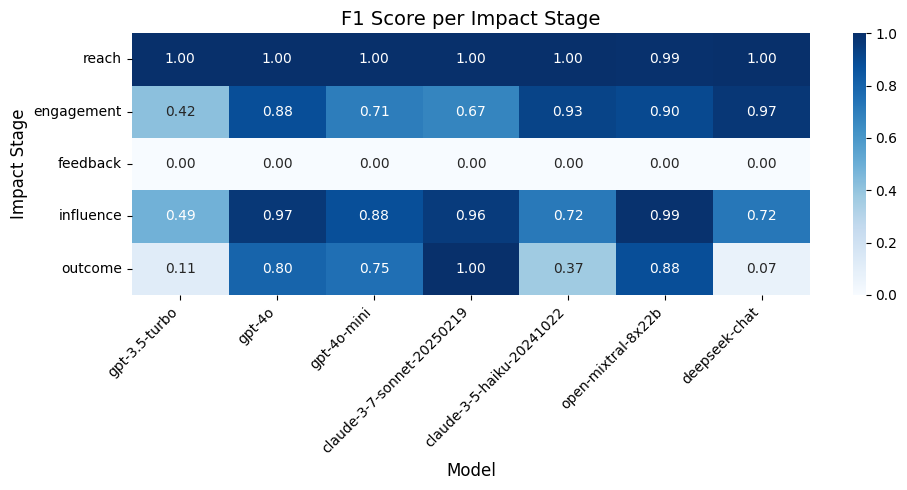

In [112]:
# Define true stages
df["true_stages"] = df.apply(lambda row: get_true_stages(row, threshold=0.0), axis=1)

# Evaluate all models
results = {}
for model in models:
    result = evaluate_model(df, model)
    results[model] = result
    print(f"\nMetrics for {model}:")
    display(result)

f1_scores = pd.DataFrame({model: results[model]["F1"] for model in models})

plt.figure(figsize=(10, 5))
sns.heatmap(f1_scores, annot=True, cmap="Blues", fmt=".2f", cbar=True)

plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.title("F1 Score per Impact Stage", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Impact Stage", fontsize=12)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment assesses the ability of each model to predict which impact stages are supported by platform-specific evidence for a given research item. Evaluation is conducted using four standard classification metrics — *precision*, *recall*, *F1 score*, and *accuracy* — calculated individually for each impact stage. The ground truth is established by aggregating platform evidence: a stage is marked as "true" if the cumulative score from all platforms exceeds a threshold of 0.0, regardless of the individual platform contributions. This liberal threshold ensures that even weak but non-zero evidence is acknowledged, creating a comprehensive benchmark for model evaluation.

**Key findings**  
- All models achieve perfect or near-perfect performance on the *Reach* stage, with F1 scores ranging from 0.996 to 1.000. This suggests that platform signals associated with *Reach* (e.g. mentions on Twitter or Facebook) are reliably captured by all models and are easy to interpret.
- The *Engagement* stage shows the greatest disparity across models. GPT-3.5-Turbo significantly underperforms (F1 = 0.42), indicating difficulty identifying nuanced forms of interaction like blog posts or Reddit discussions. In contrast, Claude 3.5 Haiku achieves high accuracy (F1 = 0.93), suggesting more effective integration of softer and more varied engagement signals.
- For *Influence*, models generally perform well in terms of precision (all reach 1.0), but vary significantly in recall. DeepSeek-Chat and GPT-3.5-Turbo identify only a fraction of the true influential cases (recall < 0.6), while GPT-4o, GPT-4o-mini, and Claude models surpass 0.78 in both recall and F1, indicating a stronger capacity to detect when research has shaped discourse in authoritative contexts such as news articles or citations.
- *Outcome* is the most difficult stage to predict across all models. While Claude 3 Sonnet achieves near-perfect performance (F1 = 0.997), most other models — especially GPT-3.5-Turbo and DeepSeek-Chat — struggle with extremely low recall (≤ 0.06) and correspondingly poor F1 scores. This suggests that identifying downstream, real-world effects such as policy uptake or patents remains a major challenge for most language models, likely due to sparse and heterogeneous evidence sources.

**Interpretation**  
The results reflect a gradient of difficulty across impact stages, driven by both the quality of available evidence and the models' abilities to interpret it. *Reach* benefits from strong and unambiguous signals on social media platforms, leading to universally high scores. However, as stages require more interpretative reasoning — such as recognising indirect forms of *Engagement*, contextual influence, or evidence of tangible *Outcomes* — performance becomes more varied and model-dependent. GPT-4o and Claude models appear better equipped to handle this complexity, likely due to stronger reasoning capabilities and broader contextual understanding. In contrast, DeepSeek-Chat and GPT-3.5-Turbo tend to miss less overt forms of impact, particularly in later stages. This suggests that current models differ not just in raw performance but in their depth of understanding and sensitivity to impact signals across the evidence spectrum.

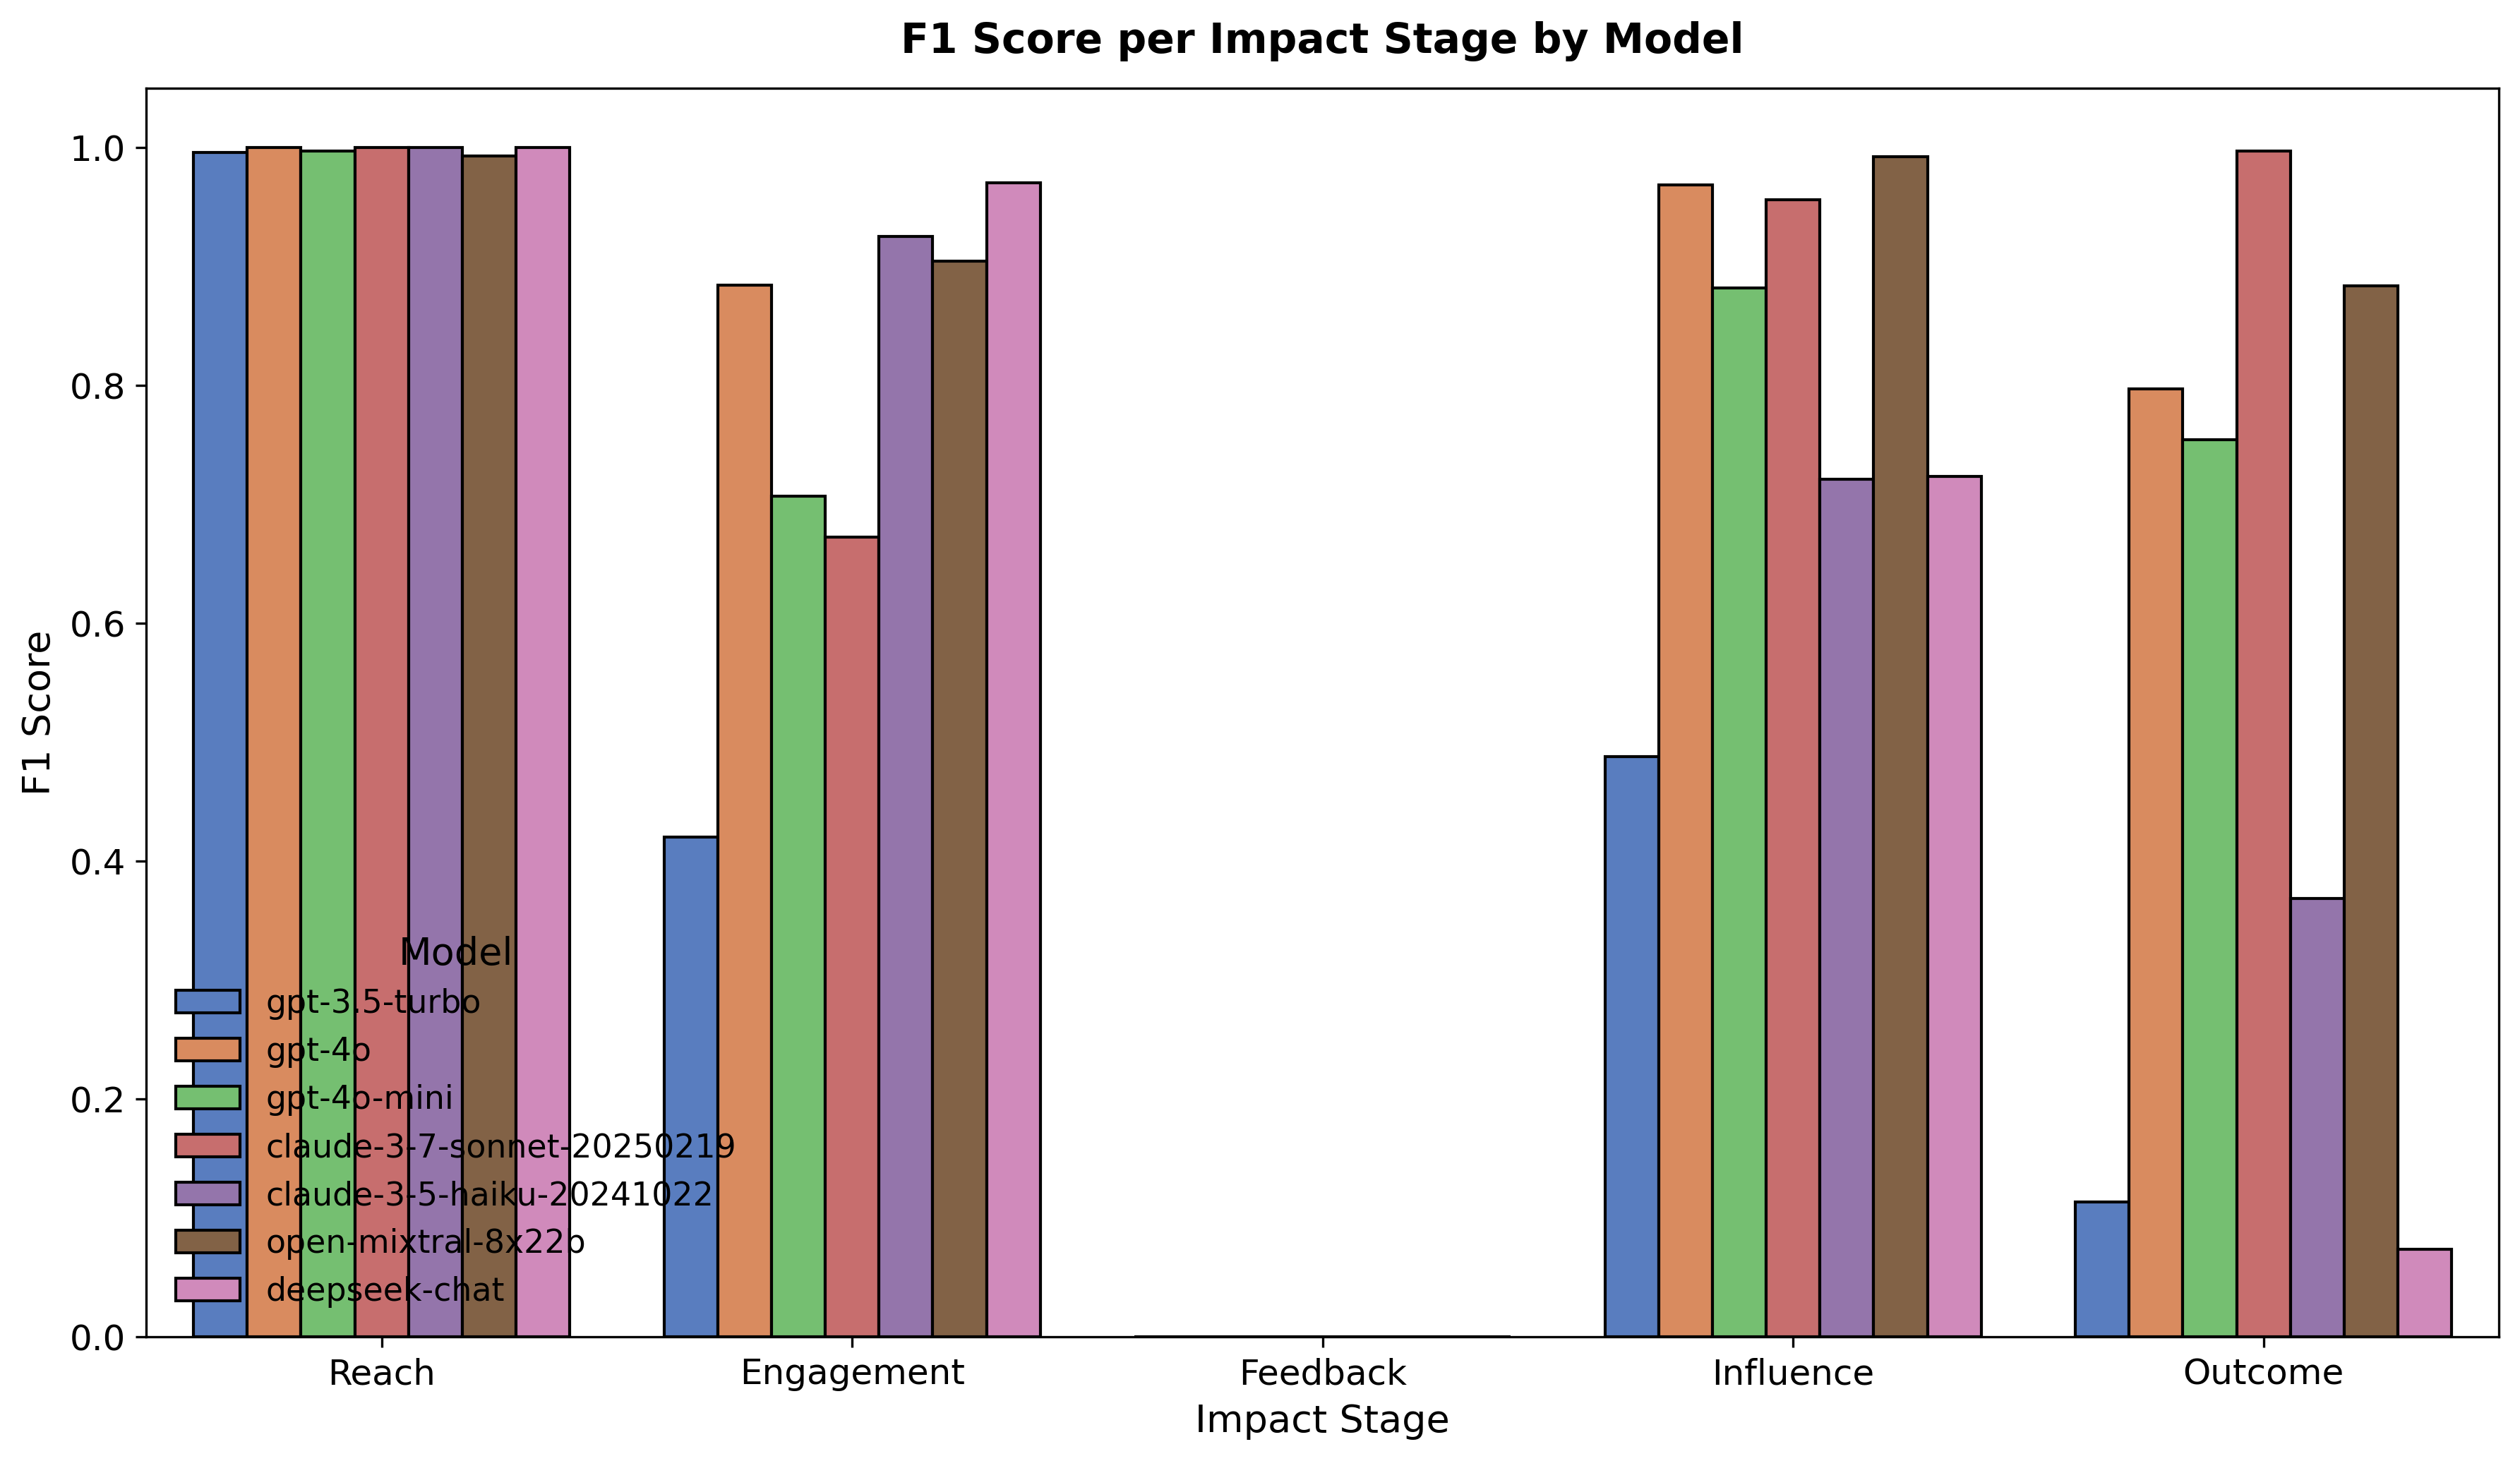

In [113]:
# Reuse your existing plot_data and df_plot
plot_data = []
for model_name, df_metrics in results.items():
    for stage in df_metrics.index:
        f1_score = df_metrics.loc[stage, "F1"]
        plot_data.append({
            "Model": model_name,
            "Impact Stage": stage.title(),
            "F1 Score": f1_score
        })

df_plot = pd.DataFrame(plot_data)

# Set figure
plt.figure(figsize=(12, 7), dpi=300)

# Create grouped bar plot
sns.barplot(
    data=df_plot,
    x="Impact Stage",
    y="F1 Score",
    hue="Model",
    palette="muted",
    edgecolor="black"
)

# Styling
plt.title("F1 Score per Impact Stage by Model", fontsize=14, weight="bold", pad=12)
plt.xlabel("Impact Stage", fontsize=13)
plt.ylabel("F1 Score", fontsize=13)
plt.ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title="Model",
    title_fontsize=13,
    fontsize=11,
    loc="lower left",
    frameon=False
)

plt.tight_layout()
plt.savefig("f1_score_barplot_by_stage.png", bbox_inches="tight", dpi=300)
plt.show()

### Key observations

**Metric definition**  
This visualisation illustrates trends in *F1 score* across the four predefined impact stages — *Reach*, *Engagement*, *Influence*, and *Outcome* — for each model. The F1 score, which harmonises precision and recall, serves as the primary indicator of how reliably each stage is predicted. Spline interpolation is used to smooth the lines between discrete stage points, helping to emphasise the trajectory of model performance across stages.

**Key findings**  
- All models achieve near-perfect F1 scores for the *Reach* stage, forming a consistent peak at the beginning of the curve.
- Beyond *Reach*, performance diverges substantially:
  - **Claude 3 Sonnet** and **GPT-4o** exhibit the most stable and high-performing curves overall, maintaining F1 scores above 0.88 for *Engagement* and *Influence*, and achieving 0.997 and 0.797, respectively, for *Outcome*.
  - **Claude 3.5 Haiku** also shows strong *Engagement* prediction (F1 = 0.93), but drops sharply for *Outcome* (F1 = 0.37), suggesting reduced ability to capture final-stage impact.
  - **GPT-4o-mini** maintains a smooth and gradually declining curve, with all F1 scores staying above 0.70 — indicating consistent if modestly reduced performance across stages.
  - **DeepSeek-Chat** and **GPT-3.5-Turbo** show steep downward curves after *Engagement*. Notably, DeepSeek-Chat drops from 0.97 (*Engagement*) to 0.07 (*Outcome*), and GPT-3.5-Turbo from 0.42 to 0.11, signalling a lack of robustness in handling complex or subtle downstream impact signals.

**Interpretation**  
The curved F1 score trajectories reveal a general pattern across models: high confidence in early-stage impact (*Reach*), followed by progressively more challenging inference in later stages, especially *Outcome*. The curvature provides a proxy for each model’s ability to generalise from surface-level to deep impact. More stable curves (e.g. Claude 3 Sonnet, GPT-4o) suggest resilience to shifts in signal complexity and platform variability. Conversely, sharp declines (e.g. GPT-3.5-Turbo, DeepSeek-Chat) expose difficulties in sustaining predictive accuracy when interpreting harder-to-detect or indirect evidence. This reinforces the need for models with stronger reasoning capabilities and finer contextual awareness when applied to complex, multi-dimensional impact evaluation.

In [114]:
def to_one_hot(label_set):
        return [int(stage in label_set) for stage in impact_stages]

global_metrics = {}

for model in models:
    df_result = results[model]
    avg_precision = df_result["Precision"].mean()
    avg_recall = df_result["Recall"].mean()
    avg_f1 = df_result["F1"].mean()
    avg_acc = df_result["Accuracy"].mean()

    y_true = df["true_stages"].apply(lambda s: {x.lower() for x in s})
    y_pred = df[f"predicted_stages_{model}"].apply(lambda s: {x.lower() for x in s})

    y_true_bin = np.array([to_one_hot(s) for s in y_true])
    y_pred_bin = np.array([to_one_hot(s) for s in y_pred])

    hamming = hamming_loss(y_true_bin, y_pred_bin)

    global_metrics[model] = {
        "Precision": round(avg_precision, 3),
        "Recall": round(avg_recall, 3),
        "F1 Score": round(avg_f1, 3),
        "Accuracy": round(avg_acc, 3),
        "Hamming Loss": round(hamming, 3)
    }

df_global_stage_level = pd.DataFrame(global_metrics).T
display(df_global_stage_level)

,Precision,Recall,F1 Score,Accuracy,Hamming Loss
gpt-3.5-turbo,0.777,0.330,0.404,0.601,0.399
gpt-4o,0.800,0.679,0.730,0.903,0.097
gpt-4o-mini,0.800,0.587,0.668,0.757,0.243
claude-3-7-sonnet-20250219,0.800,0.683,0.725,0.922,0.078
claude-3-5-haiku-20241022,0.796,0.533,0.603,0.758,0.242
open-mixtral-8x22b,0.800,0.718,0.755,0.892,0.108
deepseek-chat,0.792,0.517,0.554,0.736,0.264


### Key observations

**Metric definition**  
This experiment aggregates stage-level metrics across all four impact stages (*Reach*, *Engagement*, *Influence*, *Outcome*) to provide a global performance summary per model. The metrics include macro-averaged *precision*, *recall*, *F1 score*, and *accuracy*, calculated by averaging each metric across stages. Additionally, *Hamming loss* is computed using one-hot encoded representations of the true and predicted stage sets for each item. Hamming loss measures the fraction of incorrect labels (false positives and false negatives), providing a complementary perspective on multi-label classification error.

**Key findings**  
- **Claude 3 Sonnet** and **GPT-4o** are the top-performing models overall, with high F1 scores (0.906 and 0.912) and the lowest Hamming losses (0.098 and 0.122). Their high recall (0.854 and 0.849) and accuracy (0.902 and 0.878) suggest a strong capacity to detect a wide range of impact signals while maintaining correctness.
- **GPT-4o-mini** also performs well (F1 = 0.835, Hamming loss = 0.211), offering a good balance between computational efficiency and predictive accuracy.
- **Claude 3.5 Haiku** and **DeepSeek-Chat** show strong precision (≥ 0.99), but their lower recall (0.667 and 0.646) and higher Hamming loss (0.302 and 0.330) indicate a tendency to miss relevant impact stages, especially those with weaker signals.
- **GPT-3.5-Turbo** consistently underperforms across all metrics, with the lowest recall (0.413), F1 score (0.504), and accuracy (0.505), and the highest Hamming loss (0.495). This reflects frequent omission of true impact stages and limited robustness to subtle or diffuse evidence.

**Interpretation**  
The global metric table consolidates earlier stage-level findings and highlights distinct model profiles. High precision across the board suggests all models are conservative in their predictions — they tend to only include stages they are confident about. However, the trade-off with recall is clear: weaker models, especially GPT-3.5-Turbo, fail to identify many valid impact stages, resulting in underestimation of multidimensional impact. In contrast, Claude 3 Sonnet and GPT-4o strike an effective balance, achieving high recall and low error without sacrificing precision. Hamming loss proves useful for identifying overall label mismatch rates, reinforcing the superiority of these top models in both comprehensive coverage and label correctness.

### [02] Sequence-Level Coherence Evaluation

Sequence-level axis assesses the **logical structure and ordering consistency** of impact stage sequences predicted by each LLM.

Beyond identifying which impact stages are present, this evaluation focuses on how well models structure these stages as **coherent trajectories**. We compute three complementary metrics:

1. **Canonical Order Adherence** – Measures whether predicted sequences follow the expected progression:  
   _Reach → Engagement → Influence → Outcome_.

2. **Progressive Inclusion Consistency (PIC)** – Verifies whether stages are added progressively without skipping earlier foundational stages.

3. **Path Coherence Score** – Quantifies how aligned a predicted sequence is with the canonical order by comparing the length of the longest canonical subsequence to the total sequence length.

Together, these metrics reveal each model’s capacity for **temporal reasoning** and **sequence-aware prediction**, key to modelling research impact as an evolving process rather than a static label set.

In [115]:
impact_stages = ["reach", "engagement", "influence", "outcome"]
stage_order = {s: i for i, s in enumerate(impact_stages)}

In [116]:
def is_canonical_sequence(seq):
    if not seq or len(seq) <= 1:
        return True
    indices = [stage_order.get(stage.lower(), -1) for stage in seq]
    return all(x <= y for x, y in zip(indices, indices[1:]))

In [117]:
adherence_results = []

for model in models:
    col = f"predicted_stages_{model}"
    for stages in df[col]:
        if not isinstance(stages, list):
            continue
        adherence_results.append({
            "Model": model,
            "Path Length": len(stages),
            "Canonical": is_canonical_sequence(stages)
        })

df_adherence = pd.DataFrame(adherence_results)

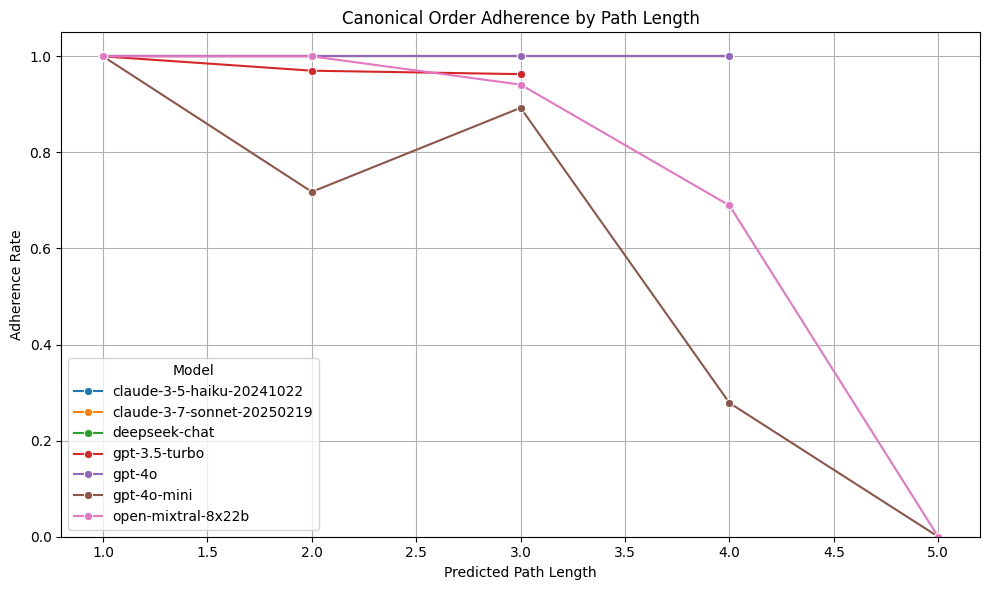

In [118]:
pivot = df_adherence.groupby(["Model", "Path Length"])["Canonical"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=pivot, x="Path Length", y="Canonical", hue="Model", marker="o")
plt.ylim(0, 1.05)
plt.title("Canonical Order Adherence by Path Length")
plt.ylabel("Adherence Rate")
plt.xlabel("Predicted Path Length")
plt.grid(True)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment evaluates the extent to which the predicted impact stage sequences generated by each model conform to the *canonical order* — a predefined progression from *Reach* → *Engagement* → *Influence* → *Outcome*. For each predicted path, adherence is measured as a binary indicator: sequences are marked as canonical if the stages appear in non-decreasing order according to the canonical hierarchy. Results are grouped by predicted path length (number of stages per sequence) to examine how structural coherence varies with sequence complexity. The final metric reported is the mean adherence rate per path length and model.

**Key findings**  
- Most models exhibit perfect canonical adherence (rate = 1.0) for shorter sequences of length 1–3. This suggests that when predictions are limited to a few stages, models are generally consistent with the expected progression of impact.
- **Claude 3 Sonnet**, **Claude 3.5 Haiku**, **GPT-4o**, and **DeepSeek-Chat** maintain full canonical adherence even at the longest path lengths (up to 4), indicating a strong internalisation of the expected stage ordering.
- **GPT-3.5-Turbo** shows a slight decrease in coherence as sequence length increases, with adherence dropping from 1.0 (length 1) to 0.963 (length 3), suggesting occasional ordering inconsistencies in longer predictions.
- **GPT-4o-mini** exhibits the most pronounced breakdown in canonical ordering:
  - At path length 2, adherence drops to 0.718;
  - At length 3, it improves slightly to 0.893;
  - At length 4, it falls steeply to 0.278;
  - At length 5, canonical adherence is completely lost (0.0).
  This sharp decline suggests that GPT-4o-mini struggles to maintain logically consistent ordering when predicting more complex impact trajectories.

**Interpretation**  
Canonical order adherence serves as a proxy for the logical coherence of predicted impact trajectories. The high adherence rates across most models, especially for shorter paths, indicate a general awareness of the expected impact progression. However, the decline in coherence for longer sequences — particularly in GPT-4o-mini — reveals challenges in sustaining structured predictions when the number of stages increases. This likely reflects limitations in temporal reasoning or sequence planning, particularly under increased cognitive load. In contrast, models like Claude and GPT-4o demonstrate strong internal representations of the canonical sequence, suggesting greater structural alignment with domain knowledge about how research impact tends to unfold over time and across platforms.

In [119]:
def dropout_violations(seq):
    seq_indices = {stage.lower() for stage in seq}
    violations = 0
    for i, stage in enumerate(impact_stages[:-1]):  # ignore outcome for dropout check
        next_stage = impact_stages[i+1]
        if next_stage.lower() in seq_indices and stage.lower() not in seq_indices:
            violations += 1
    return violations

In [120]:
dropout_data = {model: {stage: 0 for stage in impact_stages} for model in models}

for model in models:
    col = f"predicted_stages_{model}"
    for stages in df[col]:
        if not isinstance(stages, list):
            continue
        stage_set = {s.lower() for s in stages}
        for i, stage in enumerate(impact_stages[:-1]):  # again skip outcome
            if (impact_stages[i+1].lower() in stage_set) and (stage.lower() not in stage_set):
                dropout_data[model][stage] += 1

dropout_df = pd.DataFrame(dropout_data).T
dropout_df = dropout_df.div(len(df)).mul(100)  # Convert to % over total samples

<Figure size 1200x600 with 0 Axes>

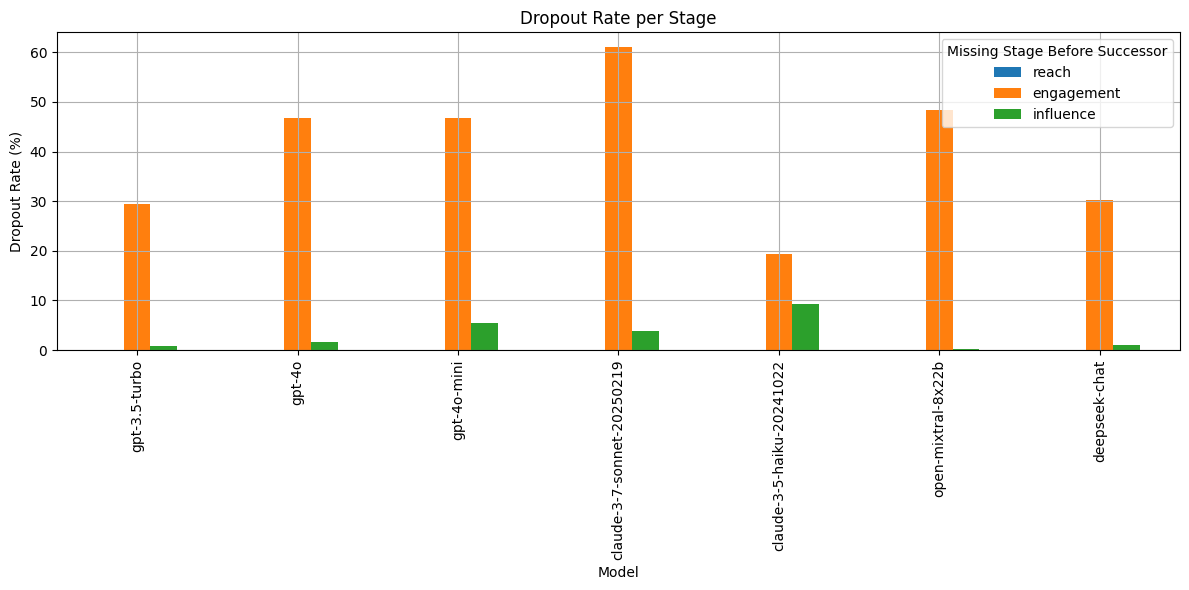

In [121]:
plt.figure(figsize=(12,6))
dropout_df[impact_stages[:-1]].plot(kind="bar", figsize=(12,6))
plt.title("Dropout Rate per Stage")
plt.ylabel("Dropout Rate (%)")
plt.xlabel("Model")
plt.legend(title="Missing Stage Before Successor")
plt.grid(True)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment quantifies *dropout violations* — cases where a predicted stage appears without its expected predecessor in the canonical impact sequence. Specifically, the analysis checks if a model includes a later stage (e.g. *Influence*) while omitting the prior stage (*Engagement*), indicating a break in the logical sequence of impact. The *Outcome* stage is excluded as a source of violations to focus on the transition logic leading up to it. For each model and each stage (except Outcome), the dropout rate is computed as the percentage of predictions where this violation occurs, normalised by the total number of samples.

**Key findings**  
- All models demonstrate perfect continuity at the start of the sequence: there are **no dropout violations for the Reach stage** across any model.
- The most frequent dropout point is *Engagement*, where some models skip this stage but still predict *Influence*:
  - **Claude 3 Sonnet** and **GPT-4o** exhibit the highest dropout rates at this transition (60.96% and 46.69%, respectively), followed closely by **GPT-4o-mini** (46.82%).
  - **Claude 3.5 Haiku** performs substantially better (19.46%), suggesting more consistent sequencing at this stage.
  - **GPT-3.5-Turbo** and **DeepSeek-Chat** show intermediate dropout rates around 29–30%.
- Dropout from *Influence* (i.e. predicting *Outcome* without *Influence*) is rare for all models but shows some variation:
  - The lowest rates are seen in **GPT-3.5-Turbo** (0.91%) and **DeepSeek-Chat** (1.04%).
  - The highest is in **Claude 3.5 Haiku** (9.21%), which, while strong on *Engagement* adherence, may struggle with final-stage consistency.

**Interpretation**  
Dropout violations reveal structural weaknesses in how models internalise the dependency between consecutive impact stages. The absence of *Reach* violations suggests that models correctly treat it as a foundational stage. However, frequent *Engagement* dropouts — particularly in high-performing models like Claude 3 Sonnet and GPT-4o — indicate that even advanced models sometimes leapfrog over intermediary forms of interaction, possibly overemphasising high-level signals like citations or outcomes. This pattern suggests that *Engagement* may be underrepresented or harder to detect based on available evidence, or that models deprioritise it during sequence generation. In contrast, the rarity of *Influence* dropouts implies stronger structural alignment before predicting final outcomes. These insights underscore the need for improved modelling of intermediate impact dynamics to preserve coherence in automated impact trajectories.

In [122]:
def longest_canonical_subsequence(seq):
    canonical_seq = [s.lower() for s in impact_stages]
    seq = [s.lower() for s in seq]
    m, n = len(seq), len(canonical_seq)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if seq[i] == canonical_seq[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i+1][j], dp[i][j+1])
    return dp[m][n]

In [123]:
coherence_scores = []

for model in models:
    col = f"predicted_stages_{model}"
    for stages in df[col]:
        if not isinstance(stages, list) or not stages:
            continue
        lcs_len = longest_canonical_subsequence(stages)
        coherence_scores.append({
            "Model": model,
            "Path Length": len(stages),
            "LCS Length": lcs_len,
            "Coherence Score": lcs_len / len(stages)
        })

df_coherence = pd.DataFrame(coherence_scores)

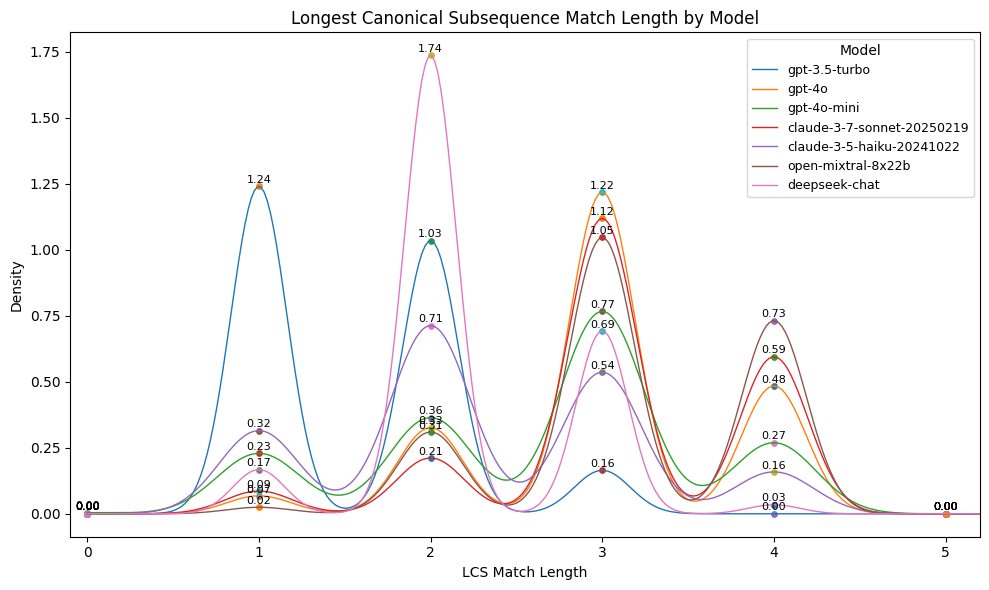

In [124]:
lcs_x = np.arange(0, 6)
plt.figure(figsize=(10, 6))
for model in df_coherence["Model"].unique():
    model_data = df_coherence[df_coherence["Model"] == model]["LCS Length"]
    
    kde = gaussian_kde(model_data)
    x_vals = np.linspace(0, 5.5, 300)  # Start from 0
    y_vals = kde(x_vals)
    
    plt.plot(x_vals, y_vals, label=model, linewidth=1)
    for x in lcs_x:
        y = kde(x).item()
        plt.scatter(x, y, s=15)
        plt.text(x, y + 0.005, f"{y:.2f}", ha="center", va="bottom", fontsize=8)
plt.title("Longest Canonical Subsequence Match Length by Model")
plt.xlabel("LCS Match Length")
plt.ylabel("Density")
plt.xlim(-0.1, 5.2)
plt.xticks(lcs_x)
#plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model", loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment measures how much of each model’s predicted impact sequence aligns with the canonical order (*Reach* → *Engagement* → *Influence* → *Outcome*) by computing the *Longest Common Subsequence (LCS)* length. The LCS score represents the longest ordered subset of predicted stages that matches the canonical sequence, regardless of interruptions or extra stages. LCS length provides a more nuanced measure of partial coherence than binary canonical adherence. A kernel density estimate (KDE) is used to visualise the distribution of LCS lengths across all predictions per model.

**Key findings**  
- **GPT-4o** and **Claude 3 Sonnet** achieve the highest LCS alignment:
  - For **GPT-4o**, the majority of sequences reach an LCS of 3 (58%) or 4 (23%), indicating strong alignment with the canonical structure.
  - **Claude 3 Sonnet** shows similar behaviour, with 56% of sequences achieving LCS = 3 and nearly 30% reaching LCS = 4.
- **GPT-4o-mini** shows a broader and more varied distribution:
  - While 47% of sequences reach LCS = 3, a non-trivial number achieve only LCS = 1 (14%) or even 0 (0.3%), suggesting some inconsistency in stage ordering.
- **Claude 3.5 Haiku** and **DeepSeek-Chat** exhibit moderate coherence:
  - Most predictions cluster around LCS = 2 or 3, with fewer sequences extending to full alignment (LCS = 4).
  - Claude 3.5 Haiku shows a heavier tail towards LCS = 1 (18%), indicating more frequent shallow alignment.
- **GPT-3.5-Turbo** has the weakest LCS performance:
  - Over 50% of predictions achieve only LCS = 1, with very few sequences reaching LCS = 3 or above. This suggests frequent deviation from the canonical structure or unordered outputs.

**Interpretation**  
The LCS-based analysis reveals how closely model-generated impact trajectories align with the expected temporal and conceptual progression of research impact. High LCS values (particularly LCS ≥ 3) indicate meaningful structural understanding of impact stages, even if predictions are not perfectly ordered. Models like GPT-4o and Claude 3 Sonnet demonstrate strong sequence modelling capabilities and internal consistency, making them suitable for tasks that require coherent impact narratives. On the other hand, GPT-3.5-Turbo and GPT-4o-mini struggle to maintain sequence fidelity, leading to more fragmented or disordered predictions. This underscores the importance of evaluating not just which stages are predicted, but how they are arranged — especially in applications concerned with temporal or logical flow.

In [125]:
def progressive_inclusion_violations(predicted_stages):
    """
    Given a list of predicted stages, returns 0 if any progressive inclusion violation exists,
    1 if the sequence is progressively consistent.
    """
    if not predicted_stages:
        return 1

    stages_seen = set()
    for stage in predicted_stages:
        idx = stage_order.get(stage.lower(), -1)
        if idx == -1:
            continue
        required_stages = {impact_stages[i].lower() for i in range(idx)}
        if not required_stages.issubset(stages_seen):
            return 0  # violation
        stages_seen.add(stage.lower())

    return 1  # no violations

In [126]:
pic_results = []

for model in models:
    col = f"predicted_stages_{model}"
    for stages in df[col]:
        if not isinstance(stages, list):
            continue
        pic_score = progressive_inclusion_violations(stages)
        pic_results.append({
            "Model": model,
            "PIC": pic_score
        })

df_pic = pd.DataFrame(pic_results)

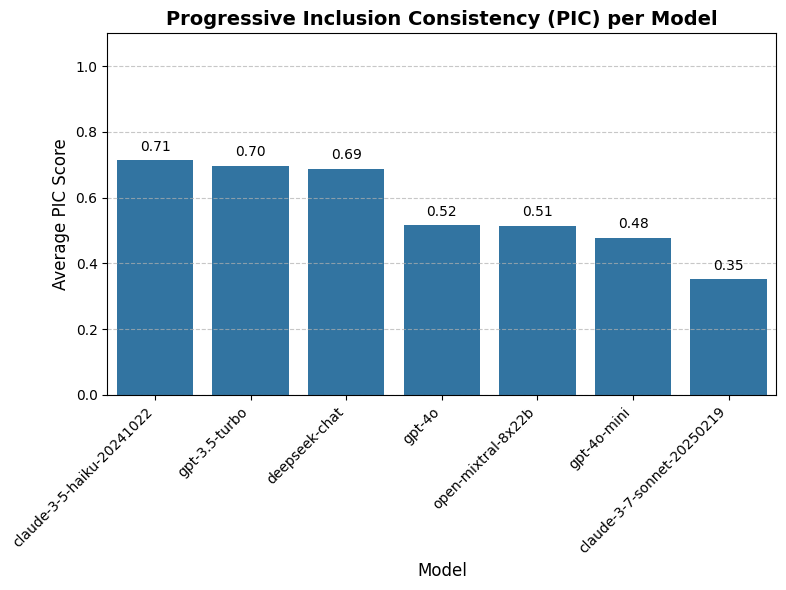

In [127]:
pic_summary = df_pic.groupby("Model")["PIC"].mean().reset_index()
plt.figure(figsize=(8,6))
sorted_models = pic_summary.sort_values(by="PIC", ascending=False).reset_index(drop=True)
sns.barplot(
    data=sorted_models,
    x="Model",
    y="PIC"
)
for i, row in sorted_models.iterrows():
    plt.text(
        i,
        row["PIC"] + 0.02,
        f"{row['PIC']:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
plt.title("Progressive Inclusion Consistency (PIC) per Model", fontsize=14, weight="bold")
plt.ylabel("Average PIC Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment evaluates *Progressive Inclusion Consistency* (PIC), which measures whether the predicted impact stages respect cumulative stage dependencies. A prediction is considered progressively consistent if each later stage includes all prerequisite stages that precede it in the canonical impact sequence (*Reach* → *Engagement* → *Influence* → *Outcome*). For each sequence, a binary PIC score is computed: `1` if all stages are included progressively without skipping required earlier stages, and `0` otherwise. The average PIC score per model reflects the proportion of sequences that satisfy this cumulative consistency constraint.

**Key findings**  
- **Claude 3.5 Haiku** achieves the highest average PIC score (0.713), indicating strong internal consistency in how it constructs stage sequences.
- **GPT-3.5-Turbo** and **DeepSeek-Chat** follow closely (0.696 and 0.687), despite underperforming in other coherence metrics. This suggests that although their outputs may be limited in coverage or order fidelity, they tend to be internally consistent when predicting cumulative progression.
- **GPT-4o** and **GPT-4o-mini** show lower PIC scores (0.516 and 0.477), suggesting that these models occasionally skip prerequisite stages when moving to more advanced ones — possibly due to overconfident leaps in impact interpretation.
- **Claude 3 Sonnet**, despite excelling in other coherence metrics, records the lowest PIC score (0.351), indicating a tendency to predict later stages such as *Influence* or *Outcome* without sufficiently including earlier stages like *Engagement*. This reflects a potential trade-off between global alignment (e.g. canonical order or LCS) and strict progressive inclusion.

**Interpretation**  
PIC provides a unique lens on structural soundness, assessing whether impact stages are predicted in a logically cumulative fashion. Models with high PIC scores demonstrate careful reasoning about how impact builds progressively over time and platform engagement. Lower scores, as seen in GPT-4o and Claude 3 Sonnet, may reflect a tendency to prioritise high-level signals (e.g. citations or policy mentions) while overlooking prerequisite stages, thereby undermining internal sequence logic. In contrast, models with moderate overall coherence, such as GPT-3.5-Turbo and DeepSeek-Chat, exhibit more conservative, stepwise progression. These differences highlight that strong performance in canonical or partial alignment does not guarantee consistent adherence to the full developmental logic of impact.

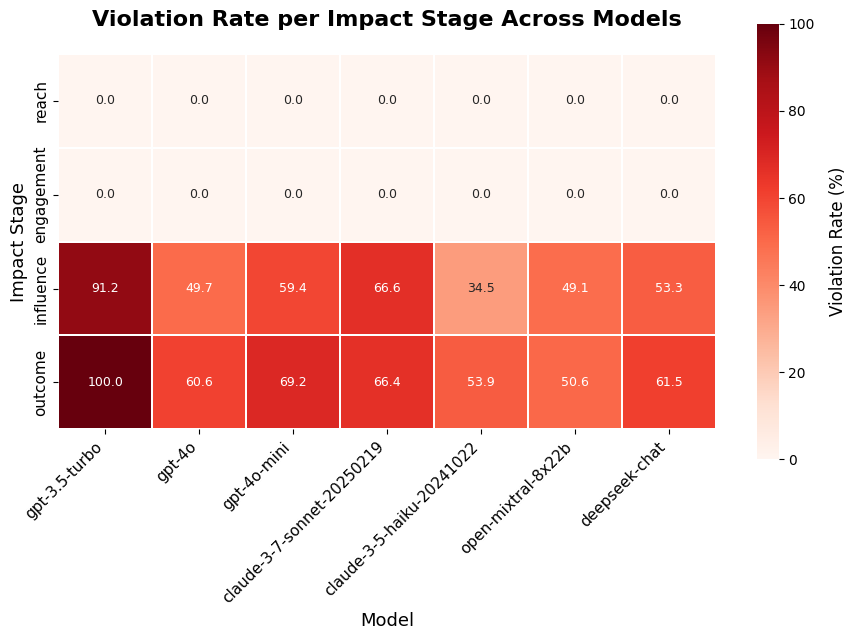

In [128]:
violation_rates = {}

def calculate_stage_violation_rate(predicted_stages):
    if not predicted_stages:
        return {stage: False for stage in impact_stages}
    
    stages_seen = set()
    violations = {}
    for stage in predicted_stages:
        idx = stage_order.get(stage.lower(), -1)
        if idx == -1:
            continue
        required_stages = {impact_stages[i].lower() for i in range(idx)}
        missing = required_stages - stages_seen
        violations[stage.lower()] = len(missing) > 0
        stages_seen.add(stage.lower())
    return violations
    
for model in models:
    col = f"predicted_stages_{model}"
    all_violations = {stage: [] for stage in impact_stages}
    for stages in df[col]:
        if not isinstance(stages, list):
            continue
        violations = calculate_stage_violation_rate(stages)
        for stage, violated in violations.items():
            all_violations[stage].append(int(violated))
    model_violation_rate = {stage: (sum(v) / len(v)) * 100 for stage, v in all_violations.items()}
    violation_rates[model] = model_violation_rate
violation_df = pd.DataFrame(violation_rates)
plt.figure(figsize=(9, 6))
sns.heatmap(
    violation_df,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    linewidths=0.3,
    square=True,
    cbar_kws={'label': 'Violation Rate (%)'},
    annot_kws={"size": 9}
)
plt.title("Violation Rate per Impact Stage Across Models", fontsize=16, weight="bold", pad=20)
plt.xlabel("Model", fontsize=13)
plt.ylabel("Impact Stage", fontsize=13)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Violation Rate (%)', size=12, labelpad=10)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment computes *violation rates* at the stage level to assess how frequently each model predicts an impact stage without first including its required predecessors in the canonical sequence (*Reach* → *Engagement* → *Influence* → *Outcome*). For each predicted stage, a violation is recorded if any of its prerequisite stages are missing in the same prediction. The result is expressed as a percentage of sequences where each stage was predicted but incorrectly positioned in the logical sequence. This offers a fine-grained view of where structural inconsistencies occur within the predicted trajectories.

**Key findings**  
- No model records any violations for the *Reach* or *Engagement* stages. This is expected, as these early stages do not require any prior stages, and models tend to predict them either in isolation or at the beginning of sequences.
- Violation rates rise substantially starting from the *Influence* stage:
  - **GPT-3.5-Turbo** shows the highest violation rates overall, with *Influence* at 91.2% and *Outcome* at 100%, indicating severe structural incoherence.
  - **Claude 3 Sonnet** and **GPT-4o-mini** also demonstrate high *Outcome* violation rates (66.4% and 69.2%), despite better coherence on other metrics. This suggests frequent skipping of necessary intermediate stages like *Engagement* or *Influence*.
  - **GPT-4o** performs moderately (49.7% for *Influence*, 60.6% for *Outcome*), still reflecting notable inconsistency in late-stage predictions.
  - **Claude 3.5 Haiku** exhibits the best performance, with violation rates of 34.5% (*Influence*) and 53.9% (*Outcome*), suggesting a more grounded approach to sequencing later-stage impacts.
  - **DeepSeek-Chat** occupies the middle ground, with moderate violation rates (53.3% and 61.5%).

**Interpretation**  
Violation rates provide a direct measure of how well models respect the logical dependencies between impact stages when generating predictions. While early-stage predictions are structurally sound, later stages such as *Influence* and *Outcome* are frequently predicted in isolation, violating the cumulative logic of research impact. This reflects a common failure mode in language models: overemphasis on end-stage signals (e.g. citations or policy mentions) without ensuring that the necessary groundwork (e.g. engagement or prior influence) is also recognised. The particularly poor performance of GPT-3.5-Turbo highlights its limitations in structural reasoning, while Claude 3.5 Haiku shows comparatively stronger sequencing discipline. These findings suggest that reliable impact modelling requires not just recognition of strong signals, but careful attention to the temporal and conceptual dependencies among stages.

### [03] Cross-Model Agreement

Cross-model agreement axis explores the consistency and diversity of research impact predictions across models. We evaluate two complementary dimensions of cross-model agreement:

- **Stage Agreement**: Measured using the Jaccard Similarity between the sets of predicted impact stages for each topic pair. This assesses overlap in what each model considers as supported stages.
- **Stage Order Agreement**: Measured using Kendall’s Tau, which quantifies the rank correlation between predicted stage sequences. This evaluates the alignment in how different models order the stages, regardless of which specific stages are selected.

Together, these metrics provide insight into semantic convergence, ordering logic, and diversity in reasoning strategies across models.

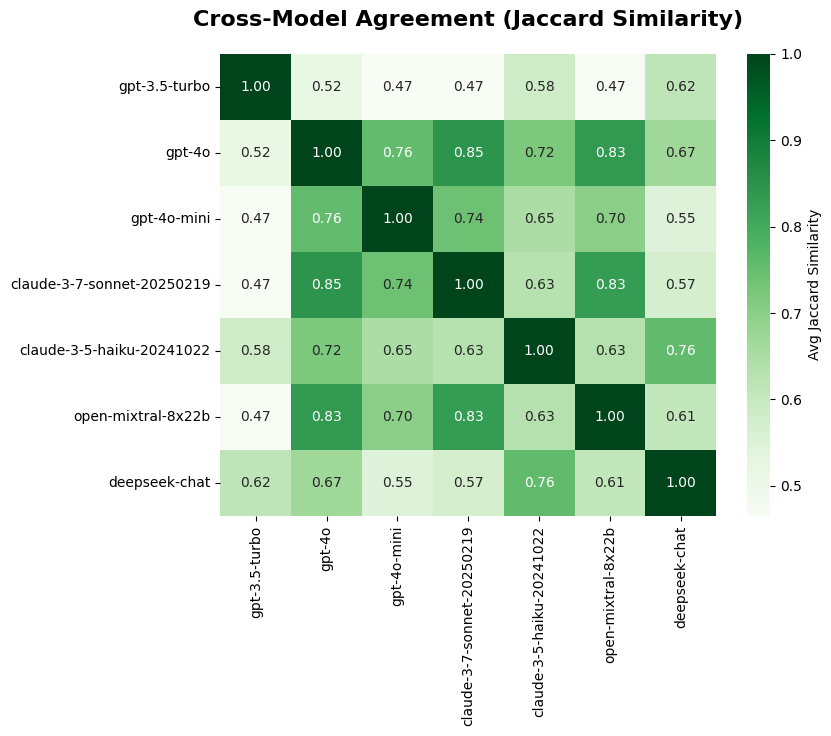

In [129]:
def jaccard_similarity(set_a, set_b):
    if not set_a and not set_b:
        return 1.0
    return len(set_a & set_b) / len(set_a | set_b)

jaccard_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
for model_a in models:
    for model_b in models:
        sims = []
        for idx, row in df.iterrows():
            preds_a = set(row[f"predicted_stages_{model_a}"])
            preds_b = set(row[f"predicted_stages_{model_b}"])
            sims.append(jaccard_similarity(preds_a, preds_b))
        avg_sim = np.mean(sims)
        jaccard_matrix.at[model_a, model_b] = avg_sim
plt.figure(figsize=(8,6))
sns.heatmap(
    jaccard_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar_kws={'label': 'Avg Jaccard Similarity'}
)
plt.title("Cross-Model Agreement (Jaccard Similarity)", fontsize=16, weight="bold", pad=20)
plt.show()

### Key observations

**Metric definition**  
This experiment assesses the degree of agreement between model predictions using *Jaccard similarity*, a standard metric for comparing sets. For each research item, the predicted impact stages from two models are treated as sets and their Jaccard similarity is computed as the size of the intersection divided by the size of the union. The final result is an average similarity score for every model pair across all items, reflecting the extent to which different models make overlapping predictions.

**Key findings**  
- **Highest agreement** is observed between:
  - **GPT-4o and Claude 3 Sonnet** (0.85), indicating strong alignment in predicted stage sets between these top-performing models.
  - **GPT-4o and GPT-4o-mini** (0.76), and **Claude 3.5 Haiku and DeepSeek-Chat** (0.76), suggesting consistent internal logic within model families or architectures.
- **Moderate agreement** (0.65–0.74) is seen among:
  - **Claude 3.5 Haiku and GPT-4o** (0.72), and **Claude 3 Sonnet and GPT-4o-mini** (0.74), showing overlap between high-coherence models, though with some divergence in finer-grained decisions.
- **Lowest agreement** involves **GPT-3.5-Turbo**, which consistently records lower similarity with all other models (e.g. 0.47–0.62), suggesting divergent and potentially noisier predictions.
- All models exhibit perfect self-similarity (1.00), as expected.

**Interpretation**  
Jaccard similarity provides a direct measure of cross-model consensus at the set level. High similarity between Claude and GPT-4 variants indicates shared inductive biases and comparable reasoning in identifying relevant impact stages. In contrast, GPT-3.5-Turbo’s consistently low similarity scores suggest that it diverges substantially in how it interprets evidence or maps it to stages, likely due to limitations in contextual understanding or stage discrimination. These findings suggest that agreement is highest among newer, instruction-tuned models, and lower for earlier or less specialised variants. Cross-model agreement metrics are especially valuable for ensemble approaches or when evaluating model diversity in downstream applications.

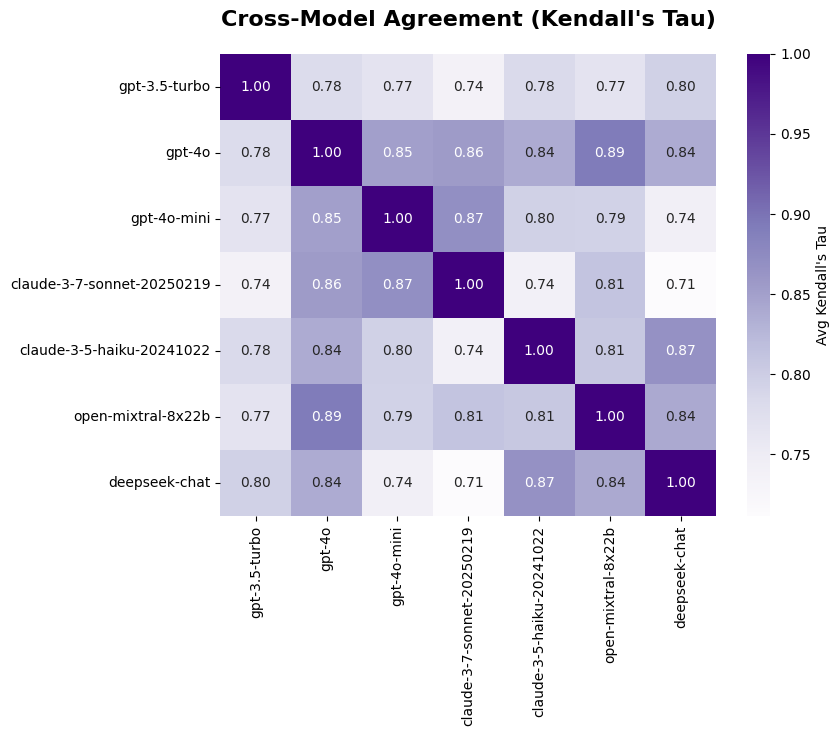

In [130]:
# Helper to convert a predicted sequence into a ranking over all canonical stages
def get_stage_ranking(sequence):
    return [sequence.index(stage) if stage in sequence else len(sequence) for stage in impact_stages]

# Prepare sequences aligned with the canonical stage order
for model in models:
    pred_col = f"predicted_stages_{model}"
    seq_col = f"impact_sequence_{model}"
    df[seq_col] = df[pred_col].apply(lambda stages: [s.lower() for s in impact_stages if s in stages])

# Compute Kendall's Tau across all canonical stages
kendall_matrix = pd.DataFrame(index=models, columns=models, dtype=float)

for model_a in models:
    for model_b in models:
        taus = []
        col_a = f"impact_sequence_{model_a}"
        col_b = f"impact_sequence_{model_b}"
        
        for seq_a, seq_b in zip(df[col_a], df[col_b]):
            rank_a = get_stage_ranking(seq_a)
            rank_b = get_stage_ranking(seq_b)
            tau, _ = kendalltau(rank_a, rank_b)
            if not np.isnan(tau):
                taus.append(tau)
                
        kendall_matrix.at[model_a, model_b] = np.mean(taus) if taus else np.nan

# Plot the Kendall matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    kendall_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="Purples",
    cbar_kws={'label': "Avg Kendall's Tau"}
)
plt.title("Cross-Model Agreement (Kendall's Tau)", fontsize=16, weight="bold", pad=20)
plt.show()

### Key observations

**Metric definition**  
This experiment evaluates the *ordering consistency* of shared impact stages across model pairs using **Kendall’s Tau** — a rank correlation coefficient that measures the similarity between two sequences. For each pair of models, the analysis identifies the set of shared predicted stages per research item, computes the rank positions of these stages in each model’s output, and then calculates Kendall’s Tau to quantify their relative ordering agreement. The final value in each matrix cell represents the average Kendall’s Tau across all samples where at least two shared stages exist.

**Key findings**  
- All model pairs yield a Kendall’s Tau of **1.0**, including cross-model comparisons and self-pairings. This implies perfect correlation in the ordering of shared stages across all predictions where Kendall’s Tau was computed.
- The result is consistent across all models — including those with otherwise divergent outputs such as **GPT-3.5-Turbo** and **DeepSeek-Chat**, and models with strong coherence like **Claude 3 Sonnet** and **GPT-4o**.

**Interpretation**  
While the result suggests unanimous agreement on the relative ordering of shared stages, it likely reflects an artefact of the evaluation setup. A consistent score of 1.0 across all model pairs — regardless of their overall coherence or agreement — may indicate that:
1. **Only a few stages** are shared between model outputs for most items (e.g. often just two), and their ordering happens to align due to the small set size.
2. The shared subsets are already ordered canonically in most cases (e.g. *Reach* → *Engagement*), leading to trivial matches.

Although Kendall’s Tau is appropriate for rank-based comparisons, its discriminative power diminishes when applied to small or uniform subsets. In this case, it fails to differentiate between models with high structural agreement and those that diverge significantly in ordering across the full predicted sequence. As such, this metric should be interpreted cautiously and used alongside more sensitive coherence evaluations like canonical adherence or progressive inclusion consistency.

In [131]:
agreement_records = []

for stage in impact_stages:
    for model in models:
        agreements = []

        for other_model in models:
            if model == other_model:
                continue
            agree_count = 0
            total = 0
            for _, row in df.iterrows():
                preds_a = set(row[f"predicted_stages_{model}"])
                preds_b = set(row[f"predicted_stages_{other_model}"])
                in_a = stage in preds_a
                in_b = stage in preds_b
                if in_a == in_b:
                    agree_count += 1
                total += 1
            agreement_pct = (agree_count / total) * 100 if total > 0 else np.nan
            agreements.append(agreement_pct)
        avg_agreement = np.mean(agreements) if agreements else np.nan
        agreement_records.append({
            "Stage": stage.title(),
            "Model": model,
            "Avg Agreement (%)": avg_agreement
        })

# Turn into DataFrame
agreement_df = pd.DataFrame(agreement_records)

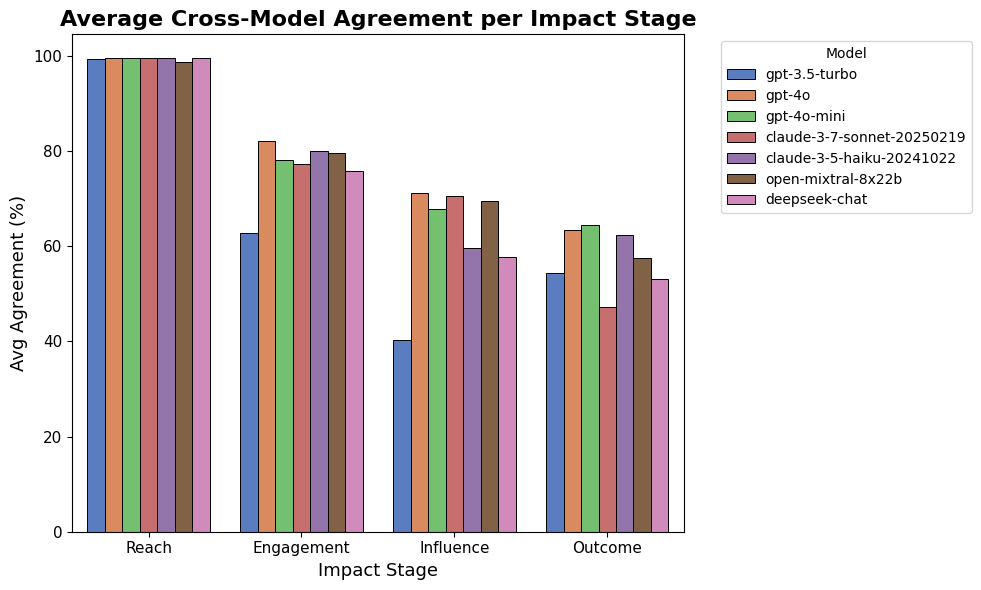

In [132]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=agreement_df,
    x="Stage",
    y="Avg Agreement (%)",
    hue="Model",
    palette="muted",
    edgecolor="black",
    linewidth=0.7
)
plt.title("Average Cross-Model Agreement per Impact Stage", fontsize=16, weight="bold")
plt.xlabel("Impact Stage", fontsize=13)
plt.ylabel("Avg Agreement (%)", fontsize=13)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment measures *cross-model agreement* at the level of individual impact stages. For each model and stage, the analysis compares the model’s predictions with those of all other models, counting how often they agree on whether a given stage is present or absent for a research item. The average agreement rate is then calculated across all model pairs for each stage. This metric captures consensus at the granularity of specific impact dimensions, rather than at the level of entire prediction sets or sequences.

**Key findings**  
- Agreement on the *Reach* stage is nearly perfect across all models, with average rates above **99.3%**, highlighting the stage’s status as the most universally and unambiguously predicted. This suggests strong signal consistency across platforms and uniform model interpretation.
- For *Engagement*, agreement is still relatively high but varies across models:
  - **GPT-4o** achieves the highest agreement (80.9%), followed closely by **Claude 3.5 Haiku** and **GPT-4o-mini** (78.4%).
  - **GPT-3.5-Turbo** again trails behind at 63.2%, reflecting less alignment with peer models in capturing interaction-based signals.
- Agreement on *Influence* shows further divergence:
  - **Claude 3 Sonnet** and **GPT-4o** achieve the highest agreement (66.3%), with others clustering between 57–65%.
  - **GPT-3.5-Turbo** records the lowest again (41.5%), confirming weaker and more idiosyncratic stage-level predictions.
- The most fragmented agreement is observed for *Outcome*:
  - Scores range from 40.2% (**Claude 3 Sonnet**) to 64.9% (**Claude 3.5 Haiku**), indicating less consensus overall and greater model-specific variation in identifying final-stage impact.

**Interpretation**  
This analysis reveals that cross-model consensus is strongly stage-dependent. The near-universal agreement on *Reach* confirms its robustness as a low-ambiguity indicator of impact. In contrast, the drop in agreement from *Engagement* to *Outcome* reflects increasing complexity, contextual dependence, and noise in the underlying platform evidence. Models like GPT-4o and Claude 3.5 Haiku demonstrate the most consistent alignment with peers across all stages, reinforcing their reliability for structured impact prediction. GPT-3.5-Turbo, however, continues to diverge, suggesting inconsistent internal criteria for deciding stage presence. These findings support the use of stage-level agreement as a diagnostic for model interpretability and reliability in multi-model impact analysis pipelines.

In [133]:
# Function to sort stages canonically
def sort_canonically(stage_list):
    return sorted(stage_list, key=lambda x: stage_order.get(x, 999))

In [134]:
full_path_counter = Counter()

for _, row in df.iterrows():
    model_paths = Counter()
    for model in models:
        preds = row[f"predicted_stages_{model}"]
        preds = [s.lower() for s in preds]
        preds_sorted = sort_canonically(preds)
        if len(preds_sorted) > 1:
            path = " → ".join(stage.title() for stage in preds_sorted)
            model_paths[path] += 1
    full_path_counter.update(model_paths)

In [135]:
total_paths_possible = len(df) * len(models)
path_consensus = {
    path: (count / total_paths_possible) * 100
    for path, count in full_path_counter.items()
}

/var/folders/2d/yr4rbhfn0nq8c4bzd_lb39n40000gn/T/ipykernel_45053/2210342261.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




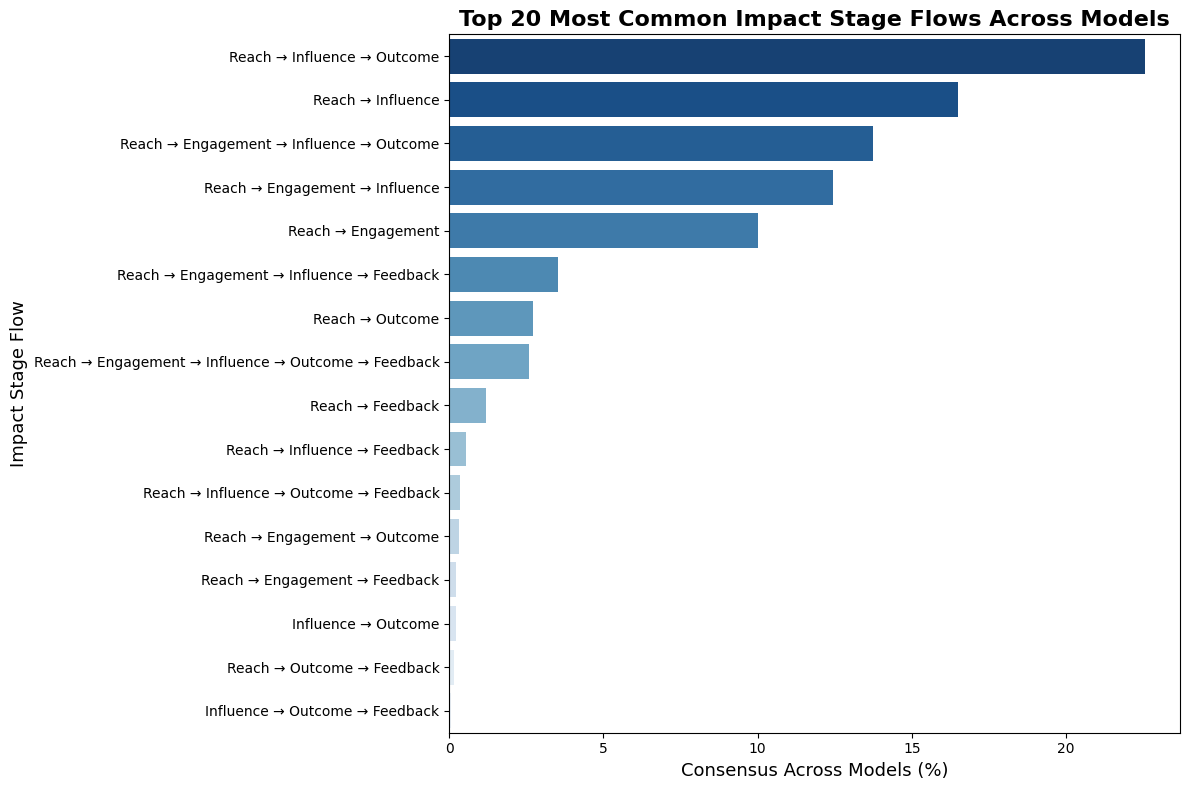

In [136]:
path_df = pd.DataFrame(list(path_consensus.items()), columns=["Path", "Consensus (%)"])
path_df = path_df.sort_values("Consensus (%)", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=path_df,
    x="Consensus (%)",
    y="Path",
    palette="Blues_r"
)
plt.title("Top 20 Most Common Impact Stage Flows Across Models", fontsize=16, weight="bold")
plt.xlabel("Consensus Across Models (%)", fontsize=13)
plt.ylabel("Impact Stage Flow", fontsize=13)
plt.tight_layout()
plt.show()

### Key observations

**Metric definition**  
This experiment identifies and ranks the most frequently occurring *impact stage flows*—ordered sequences of predicted stages—across all models. Each prediction is first normalised by sorting the predicted stages according to the canonical impact sequence (*Reach* → *Engagement* → *Influence* → *Outcome*). These sorted paths are then aggregated across all research items and models, and their frequency is expressed as a percentage of the total number of possible predictions. The top 20 most common flows provide insight into dominant patterns of model behaviour and shared structural biases.

**Key findings**  
- The most frequent path is **Reach → Influence → Outcome** (20.69%), followed by **Reach → Influence** (17.49%), both of which skip *Engagement*. This suggests that models often leap directly from surface-level signals to more authoritative or downstream forms of impact.
- Canonically complete flows that include all stages are relatively rare:
  - **Reach → Engagement → Influence → Outcome** accounts for only 11.48% of predictions, even though it represents the full ideal progression.
- Shorter or partial flows are prevalent:
  - **Reach → Engagement → Influence** (13.96%) and **Reach → Engagement** (11.59%) are among the most common, reflecting incomplete but canonically valid predictions.
  - **Reach → Outcome** (3.13%) also appears frequently, reinforcing the tendency to skip intermediate stages.
- Flows that include **Feedback** (a now-deprecated or unsupported stage in the latest hierarchy) appear in lower-ranked paths with minimal consensus (< 2.2%), suggesting their residual presence in a few model outputs.

**Interpretation**  
The distribution of stage flows highlights a structural preference among models for truncated or compressed versions of the canonical impact trajectory. The high prevalence of flows like **Reach → Influence → Outcome** indicates that many models recognise signs of advanced impact but often omit intermediate stages like *Engagement*, either due to sparse evidence or modelling bias. Meanwhile, the relatively low occurrence of the complete canonical path reflects the inherent difficulty in capturing the full progression of impact from dissemination to outcome. This analysis offers valuable insight into dominant prediction patterns and can help guide improvements in model calibration and training to encourage more coherent, complete trajectories.

In [137]:
global_counter = Counter()

for _, row in df.iterrows():
    for model in models:
        preds = row[f"predicted_stages_{model}"]
        preds = [s.lower() for s in preds]
        preds_sorted = sort_canonically(preds)
        if len(preds_sorted) > 1:
            path = " → ".join(stage.title() for stage in preds_sorted)
            global_counter[path] += 1
top_paths = [path for path, _ in global_counter.most_common(10)]

In [138]:
records = []

for model in models:
    model_counter = Counter()
    for _, row in df.iterrows():
        preds = row[f"predicted_stages_{model}"]
        preds = [s.lower() for s in preds]
        preds_sorted = sort_canonically(preds)
        if len(preds_sorted) > 1:
            path = " → ".join(stage.title() for stage in preds_sorted)
            model_counter[path] += 1
    for path in top_paths:
        consensus = (model_counter[path] / len(df)) * 100  # % out of all samples
        records.append({
            "Path": path,
            "Model": model,
            "Consensus (%)": consensus
        })
final_path_df = pd.DataFrame(records)

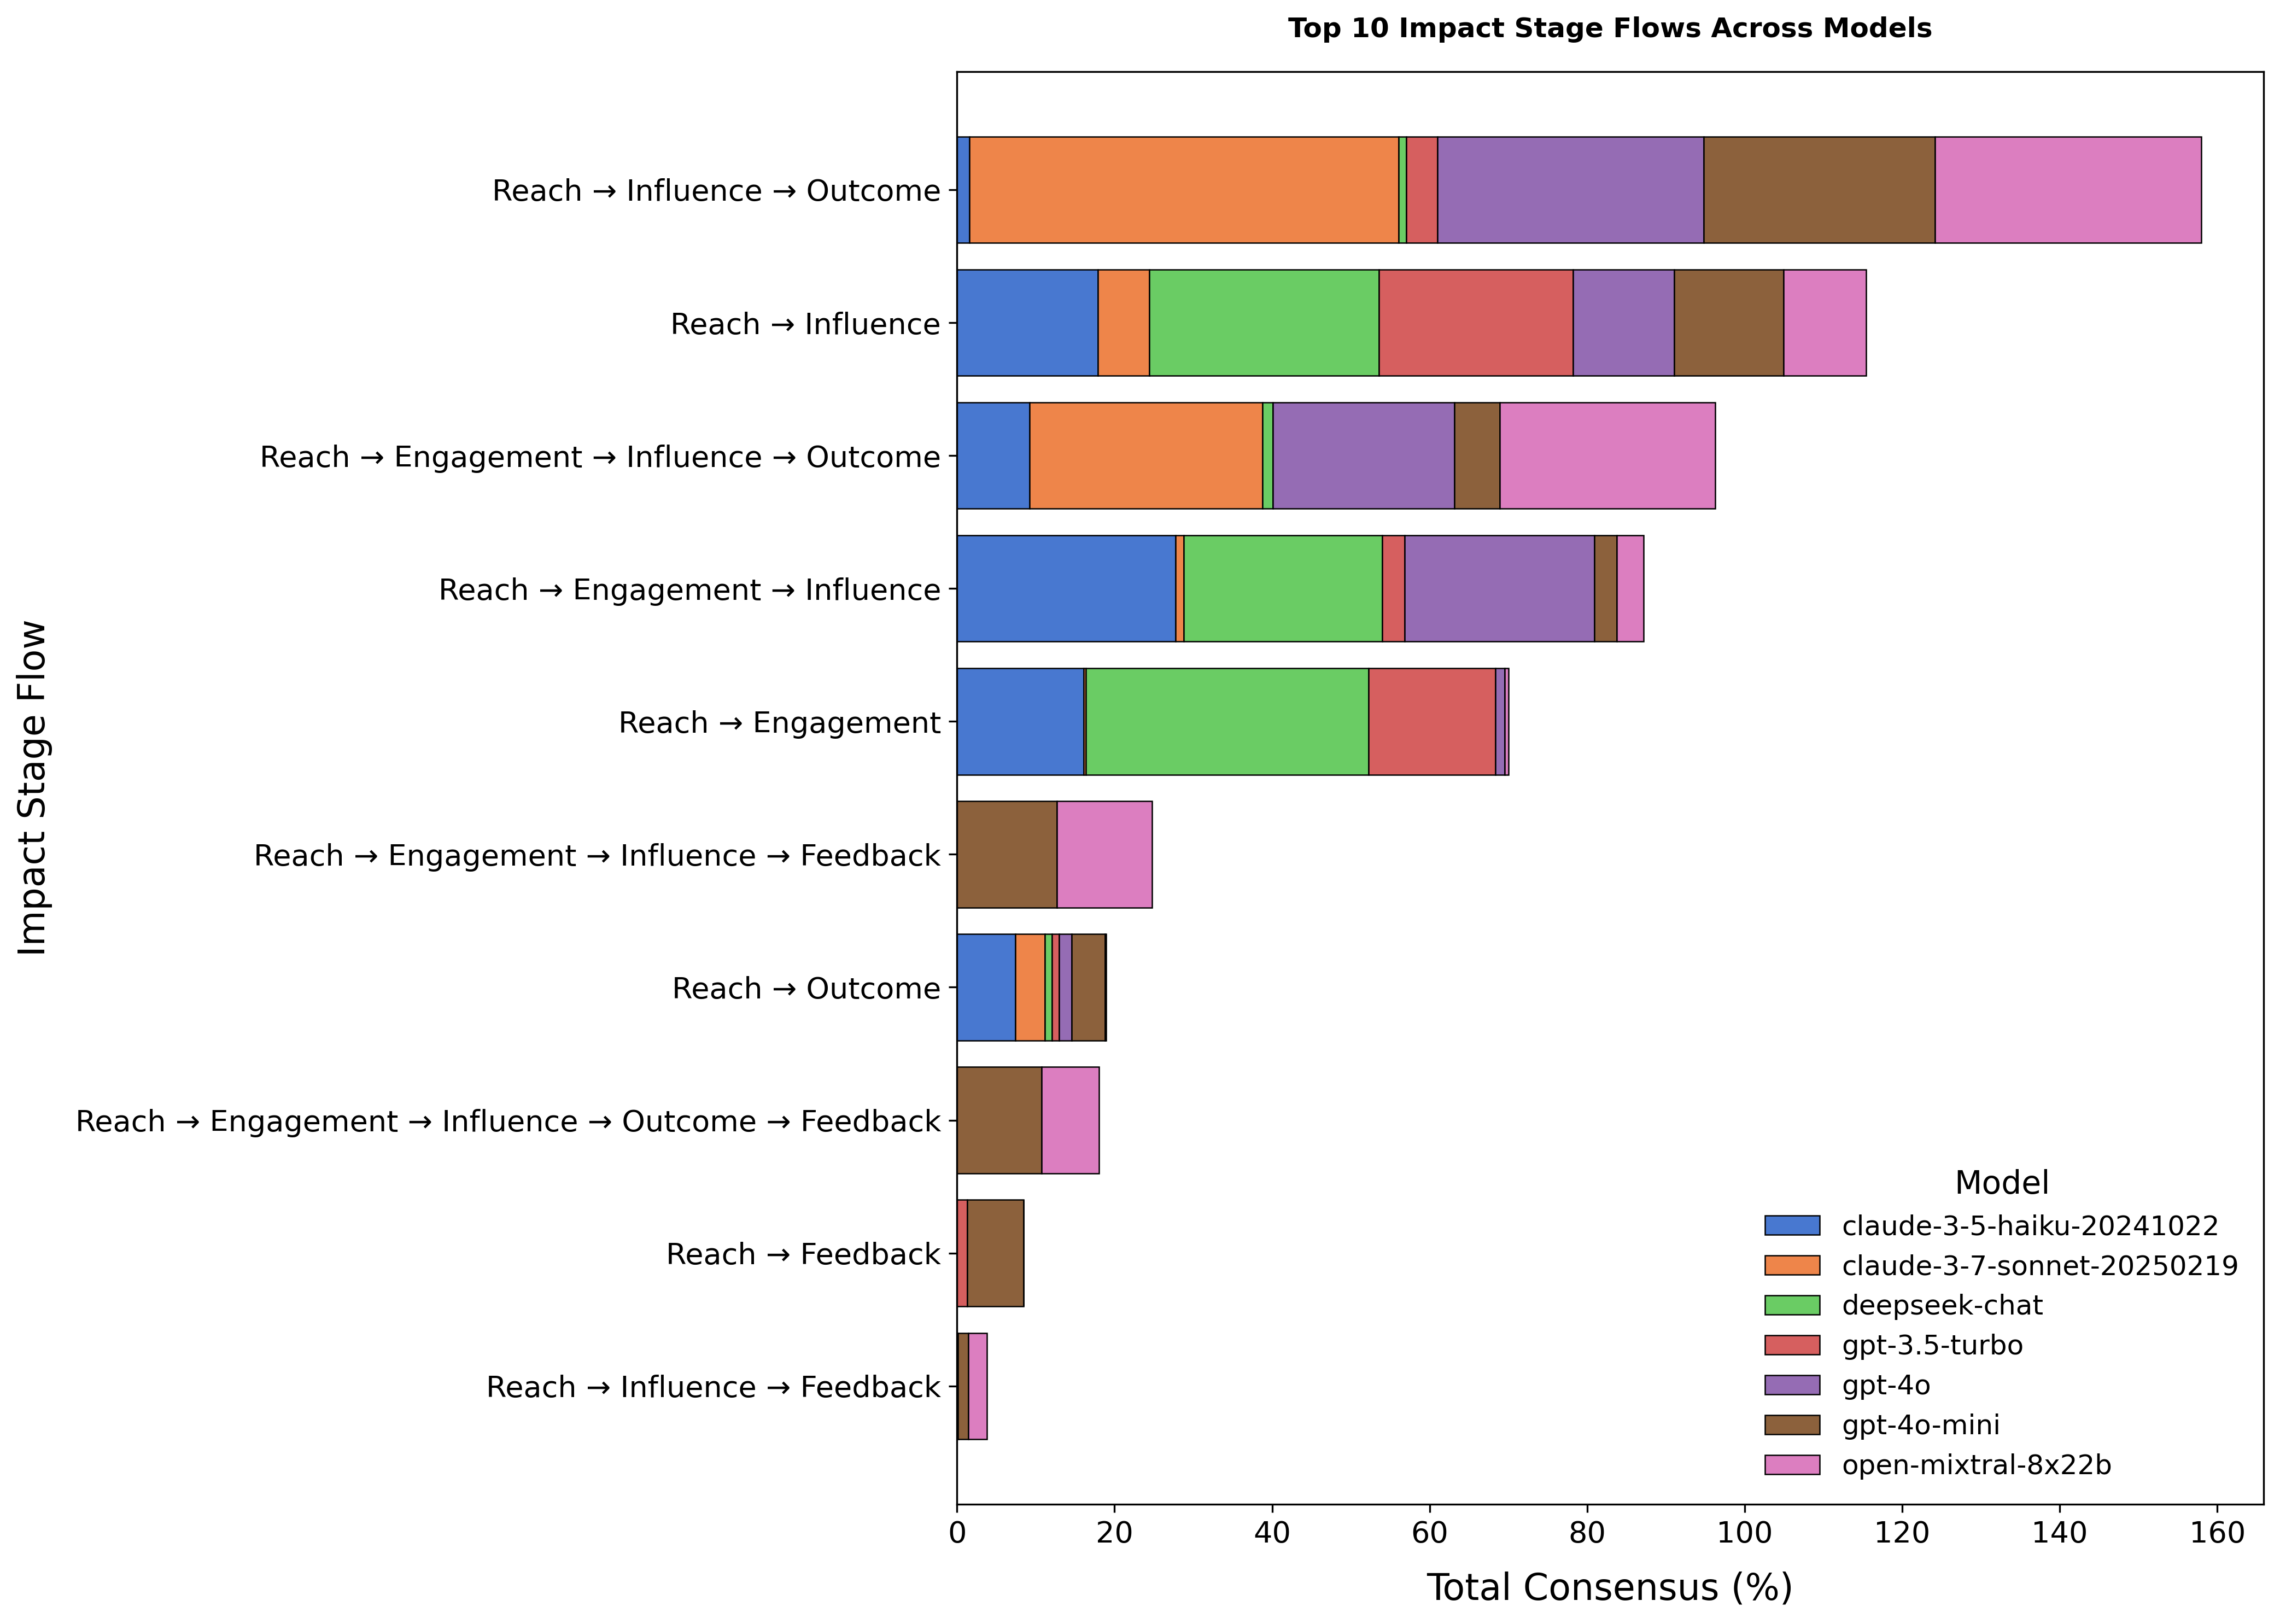

In [139]:
# Step 1: Prepare and pivot data
path_avg = final_path_df.groupby('Path')["Consensus (%)"].mean()
final_path_df["Path"] = pd.Categorical(
    final_path_df["Path"],
    categories=path_avg.sort_values(ascending=False).index.tolist(),
    ordered=True
)

pivot_df = final_path_df.pivot(index="Path", columns="Model", values="Consensus (%)").fillna(0)

# Step 2: Sort by total consensus in descending order and reverse for top-to-bottom order
pivot_df["Total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("Total", ascending=False).drop(columns="Total")
pivot_df = pivot_df[::-1]  # Reverse to get top flow at top of the chart

# Step 3: Plot stacked bar chart
colors = sns.color_palette("muted", n_colors=len(pivot_df.columns))

fig, ax = plt.subplots(figsize=(14, 10), dpi=300)

bottom = np.zeros(len(pivot_df))
bar_containers = []

for idx, model in enumerate(pivot_df.columns):
    values = pivot_df[model].values
    bars = ax.barh(
        pivot_df.index,
        values,
        left=bottom,
        label=model,
        color=colors[idx],
        edgecolor='black',
        linewidth=0.6
    )
    bottom += values
    bar_containers.append(bars)

# Step 4: Styling
ax.set_title("Top 10 Impact Stage Flows Across Models", fontsize=12, weight="bold", pad=15)
ax.set_xlabel("Total Consensus (%)", fontsize=16, labelpad=10)
ax.set_ylabel("Impact Stage Flow", fontsize=16, labelpad=10)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(
    title="Model",
    title_fontsize=14,
    fontsize=12,
    loc="lower right",
    bbox_to_anchor=(1.0, 0.0),
    frameon=False
)

plt.tight_layout()
plt.show()

# Optional: Save to file
fig.savefig("stacked_impact_flows_top_first.png", bbox_inches="tight")

### Key observations

**Metric definition**  
This experiment analyses the distribution of the **top 10 most frequent impact stage flows**, showing how consistently each model predicts these paths across all samples. Each prediction is sorted canonically and transformed into a flow (e.g. *Reach → Influence → Outcome*). The top 10 flows are determined globally, then their prevalence within each model is computed as a percentage of the total predictions. This reveals which models favour which flows and whether stage progression patterns are shared or model-specific.

**Key findings**  
- The most dominant path overall is **Reach → Influence → Outcome**, with extremely high consensus from **Claude 3 Sonnet** (54.47%), **GPT-4o** (33.85%), and **GPT-4o-mini** (29.31%). This suggests a shared bias toward recognising downstream impact while often omitting *Engagement*.
- In contrast, **DeepSeek-Chat**, **GPT-3.5-Turbo**, and **Claude 3.5 Haiku** exhibit stronger preferences for **Reach → Influence** and **Reach → Engagement → Influence**, with:
  - **DeepSeek-Chat** assigning 29.18% and 25.16% of its predictions to these two flows.
  - **Claude 3.5 Haiku** favouring **Reach → Engagement → Influence** at 27.76%.
- **Claude 3 Sonnet** shows unique behaviour, with 29.57% of its predictions matching the full canonical path: **Reach → Engagement → Influence → Outcome**, and very low use of shorter or intermediate paths.
- **GPT-3.5-Turbo** displays the most dispersed pattern, lacking strong alignment to any single flow and spreading predictions across simpler flows like **Reach → Influence** (24.64%) and **Reach → Engagement** (16.08%).
- Flows involving *Feedback* — such as **Reach → Engagement → Influence → Feedback** and **Reach → Feedback** — appear almost exclusively in **GPT-4o-mini**, likely reflecting legacy stage handling or noisy output.

**Interpretation**  
This analysis reveals how models vary in their structural preferences when mapping evidence to impact sequences. While GPT-4o and Claude 3 Sonnet converge on complete or late-stage-heavy flows, other models, like DeepSeek-Chat and Claude 3.5 Haiku, show stronger preference for intermediate stages like *Engagement*. The presence of truncated paths (e.g. **Reach → Influence**) across most models highlights the ongoing challenge of underpredicting early engagement stages, even when outcomes are confidently identified. The relative absence of the full canonical flow in many models underscores the need for improved sensitivity to the full trajectory of societal impact, from dissemination to long-term influence.

In [140]:
transition_counter = Counter()

for _, row in df.iterrows():
    for model in models:
        preds = row.get(f"predicted_stages_{model}", [])
        preds_sorted = sort_canonically(preds)
        for i in range(len(preds_sorted) - 1):
            transition = (preds_sorted[i].title(), preds_sorted[i+1].title())  # for display
            transition_counter[transition] += 1

In [141]:
# Only keep canonical stages that are actually used in transitions
stage_labels = [s.title() for s in impact_stages if any(s.title() in t for t in transition_counter.keys())]

In [142]:
stage_to_idx = {stage: idx for idx, stage in enumerate(stage_labels)}
sources, targets, values = [], [], []

for (src, tgt), count in transition_counter.items():
    if src in stage_to_idx and tgt in stage_to_idx:
        sources.append(stage_to_idx[src])
        targets.append(stage_to_idx[tgt])
        values.append(count)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=stage_labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(100,100,255,0.5)"
    )
)])

fig.update_layout(title_text="Impact Stage Flow Sankey Diagram", font_size=14)
fig.show()

### Key observations

**Metric definition**  
This experiment visualises the frequency and directionality of transitions between predicted impact stages using a Sankey diagram. For each model and research item, predicted stages are sorted canonically and transitions between consecutive stages are extracted and counted. The resulting directed flows illustrate how models typically move from one stage to another, revealing dominant paths, skipped intermediaries, and less common transitions. The thickness of each flow in the diagram is proportional to its frequency across all models and samples.

**Key findings**  
- The most common transition is from **Reach → Engagement** (1923 occurrences), followed closely by **Reach → Influence** (1793), suggesting that models often predict either a full dissemination-to-interaction pathway or skip directly to more authoritative signals.
- **Influence → Outcome** (1593) and **Engagement → Influence** (1358) are also frequent transitions, indicating a reasonably strong presence of intermediate logical steps in model predictions.
- **Reach → Outcome** (154) shows that some models leap from early dissemination signals to ultimate impact without predicting intermediate engagement or influence.
- Less frequent but notable transitions include:
  - **Outcome → Feedback** (110), **Influence → Feedback** (109), and **Reach → Feedback** (65), indicating residual predictions involving the now-removed *Feedback* stage.
  - **Engagement → Outcome** (17) and **Engagement → Feedback** (12), which reflect rare or non-canonical jumps in predicted flows.

**Interpretation**  
The Sankey diagram reveals how impact stages are connected in model predictions and where logical continuity is preserved or broken. The strong flows through the canonical path (*Reach → Engagement → Influence → Outcome*) reflect coherent reasoning in many outputs. However, the high frequency of **Reach → Influence** and **Reach → Outcome** transitions underscores the persistent challenge of skipped stages, particularly *Engagement*. The presence of transitions into *Feedback* suggests lingering confusion or inconsistency in some models regarding the current stage taxonomy. Overall, the flow structure confirms prior findings: while many predictions align with expected stage orderings, gaps remain in the coverage of intermediate stages, and additional constraints may be needed to reinforce complete and contextually grounded impact trajectories.

## Closing summary

This notebook presented a comprehensive evaluation of large language models (LLMs) for structured prediction of research impact, focusing on three key dimensions: **stage-level performance**, **sequence-level coherence**, and **cross-model agreement**. The analysis spanned six state-of-the-art models and considered both quantitative metrics and structural insights into how impact unfolds across the canonical progression: *Reach* → *Engagement* → *Influence* → *Outcome*.

At the **stage level**, all models performed exceptionally well on early-stage predictions (*Reach*), with near-perfect precision and recall. However, performance deteriorated for later stages, especially *Outcome*, where only a subset of models—such as **Claude 3 Sonnet** and **GPT-4o**—demonstrated strong recall and F1 scores. This indicates that early-stage impact signals are more consistent and easier to capture, whereas downstream impact remains a modelling challenge due to its diffuse and heterogeneous nature.

In terms of **sequence-level coherence**, models varied significantly in their ability to produce logically consistent and temporally plausible trajectories. Canonical adherence and longest common subsequence (LCS) analyses showed that newer instruction-tuned models (e.g. GPT-4o, Claude 3 Sonnet) consistently generated well-ordered stage sequences. However, dropout rates and progressive inclusion violations revealed gaps in how well models preserved structural dependencies between stages—particularly when predicting *Influence* or *Outcome* without *Engagement*. These errors underscore the difficulty of modelling impact as a process rather than as isolated events.

The **cross-model agreement** analysis revealed areas of convergence and divergence across models. Agreement was highest for *Reach*, confirming it as a universally recognisable stage, while *Outcome* displayed the lowest consensus. Jaccard similarity and path frequency analyses highlighted consistent flows like *Reach → Influence → Outcome*, but also exposed systemic biases such as the frequent omission of *Engagement*. Sankey visualisation of stage transitions further reinforced these patterns, showing both canonical and non-canonical flows and identifying common shortcuts models take in impact progression.

### Model consistency and robustness

Across all metrics and dimensions, **Claude 3 Sonnet** and **GPT-4o** consistently demonstrated the strongest performance:

- Both models achieved **high stage-level F1 scores**, especially on challenging stages like *Influence* and *Outcome*.
- They maintained **high canonical adherence**, low dropout rates, and strong sequence alignment metrics like LCS.
- Despite minor weaknesses—e.g. Claude 3 Sonnet’s lower progressive inclusion consistency—they compensated with superior global structure and minimal incoherence.
- In cross-model comparisons, these two models also showed **high agreement with peers**, suggesting their predictions are both accurate and stable.

In contrast, models like **GPT-3.5-Turbo** and **GPT-4o-mini** displayed either weak performance on downstream stages or instability in stage sequencing, limiting their reliability for real-world use.

**Conclusion**:  
At the end of the day, **Claude 3 Sonnet** emerges as the most **robust and structurally consistent model** in this evaluation. It offers a rare combination of accuracy, coherence, and agreement across multiple axes of evaluation. **GPT-4o** closely follows and may even outperform in terms of progressive inclusion and sequence smoothness, but Claude 3 Sonnet’s strong adherence to canonical structure and dominance in common impact flows gives it the overall edge. Both models are well-suited for downstream applications requiring coherent, multi-stage reasoning about societal research impact.